In [4]:
import numpy as np
# from qutip import *
from scipy.sparse import diags
import scipy.linalg as la
import math as math
import matplotlib.pyplot as plt
import timeit
import seaborn as sns
from matplotlib import ticker
import matplotlib.patches as mpatches
st = sns.axes_style("ticks")
sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (12,9)})
   
#sns.set(color_codes = True)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

from numpy import ndarray

class myarray(ndarray):    
    @property
    def H(self):
        return self.conj().T

### Writing the Ground Hamiltonian in Matrix Form

[[0. 1. 0. ... 0. 0. 0.]
 [1. 0. 1. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 1. 0. 1.]
 [0. 0. 0. ... 0. 1. 0.]]


/Users/fabianjaeger/opt/anaconda3/envs/QM/lib/python3.8/site-packages/numpy/core/_asarray.py:136: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order, subok=True)


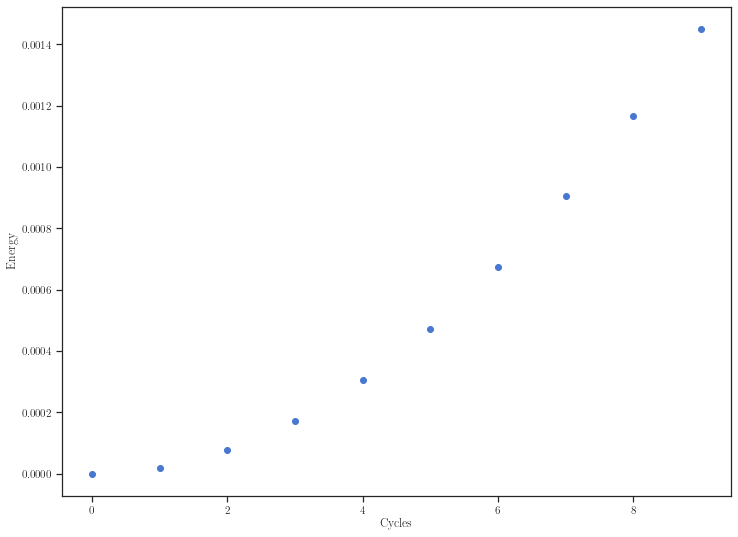

Time:  2.8733431700093206


In [130]:
start = timeit.default_timer()
L = 1000
# Computing the Matrix Elements of the Hamiltonian H_0
k = np.array([np.ones(L-1),np.ones(L-1)])
offset = [-1,1]
H_0 = diags(k,offset).toarray()
print(H_0)
# H_0[L-1, L-1] = 1
# H_0[0,0] = 1

# Periodic Boundary Conditions

eigvals0, eigvecs0 = np.linalg.eigh(H_0)
# print(eigvals0)

# Sorting the eigenvalues and eigenvectors from smallest to largest eigenvalues
idx0 = eigvals0.argsort()[::1]   
eigenValues0 = eigvals0[idx0]
eigenVectors0 = eigvecs0[:,idx0]

# Computing the Matrix Elements of the Hamiltonian H_1
H_1 = np.zeros((L,L))
for n in range(L):
    for m in range(L):
        if m == n+1 :
            H_1[n,m] = np.sin((math.pi)*(n+0.5)/L)**2
#             H_1[n,m] = np.round((np.sin((math.pi)*(n+0.5)/L)),2)
        if m == n-1:
            H_1[n,m] = np.sin((math.pi)*(n-0.5)/L)**2 
eigvals1, eigvecs1 = la.eig(H_1)

# Sorting the eigenvalues and eigenvectors from smallest to largest eigenvalues
idx1 = eigvals1.argsort()[::1]   
eigenValues1 = eigvals1[idx1]
eigenVectors1 = eigvecs1[:,idx1]


# Check whether the matrix is symmetric
# print(H_1 - H_1.transpose())

# Define the unitary transformations
U = eigenVectors0
V = eigenVectors1
V_her = np.conjugate(V.transpose())
W = np.dot(V_her, U)
W_her = np.conjugate(W.transpose())

# Lenghts of the cycles
T_0 = 0.95*L
T_1 = 0.05*L

# Create the imaginary i
z = complex(0,1)

# Creating the diagonal matrix for the exponential eigenvalues of H_0
exponential_eig0 = []
for i in range(eigenValues0.size):
    exponential_eig0.append(np.exp(-z*eigenValues0[i]* T_0))
diagonal_eig0 = np.diag(exponential_eig0)

# # Creating the diagonal matrix for the exponential eigenvalues of H_1
exponential_eig1 = []
for i in range(eigenValues1.size):
    exponential_eig1.append(np.exp(-z*eigenValues1[i]*T_1))
diagonal_eig1 = np.diag(exponential_eig1)

W1_T1 = np.dot(diagonal_eig1, W)
W0_T0 = np.dot(diagonal_eig0, W_her)

# Ground State Energy
n_cycles = 0
Floquet_cycle = np.dot(W0_T0, W1_T1)
Floquet_cycles = np.linalg.matrix_power(Floquet_cycle, n_cycles)
mathcal_W = np.dot(U, Floquet_cycles)
mathcal_W_her = np.conjugate(mathcal_W.transpose())
mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
Two_Point_Corellation_Matrix = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)

Ground_State_Energy_H0 = 0

for i in range(L-1):
    Ground_State_Energy_H0 += 0.5*Two_Point_Corellation_Matrix[i,i+1] + 0.5*Two_Point_Corellation_Matrix[i+1,i]
n = [i for i in range(10)]

# Energies for n cycles
def TotalEnergy():
    Total_Energy_H0_array = [None] * (len(n))
    for i in range(len(n)):
        Floquet_cycles = np.linalg.matrix_power(Floquet_cycle, n[i])
        mathcal_W = np.dot(U, Floquet_cycles)
        mathcal_W_her = np.conjugate(mathcal_W.transpose())
        mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
        mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
        Two_Point_Corellation_Matrix = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)
        Total_Energy = 0
        for l in range(L-1):
            Total_Energy += 0.5*Two_Point_Corellation_Matrix[l,l+1] + 0.5*Two_Point_Corellation_Matrix[l+1,l]
        Total_Energy_H0_array[i] = Total_Energy - Ground_State_Energy_H0

    plt.scatter(n, Total_Energy_H0_array)
    plt.ylabel('Energy')
    plt.xlabel('Cycles')
    plt.show()
    
TotalEnergy()
# Runtime for the program
stop = timeit.default_timer()
print('Time: ', stop - start)  

#### Energy Density

[[-0.78200953+0.62326648j  0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j         -0.76420733+0.64497067j  0.        +0.j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j         -0.73320615+0.68000643j
  ...  0.        +0.j          0.        +0.j
   0.        +0.j        ]
 ...
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ... -0.73320615-0.68000643j  0.        +0.j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j         -0.76420733-0.64497067j
   0.        +0.j        ]
 [ 0.        +0.j          0.        +0.j          0.        +0.j
  ...  0.        +0.j          0.        +0.j
  -0.78200953-0.62326648j]]


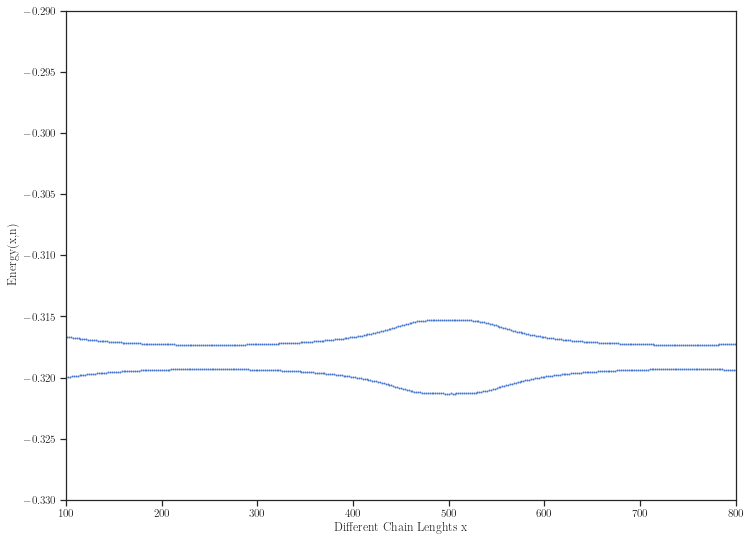

In [3]:
def EnergyDensity(L,n_cycles):
    k = np.array([np.ones(L-1),np.ones(L-1)])
    offset = [-1,1]
    H_0 = diags(k,offset).toarray()
    eigvals0, eigvecs0 = la.eigh(H_0)
    H_0 = 0.5 * H_0

#     print(H_0)
    # Sorting the eigenvalues and eigenvectors from smallest to largest eigenvalues
    idx0 = eigvals0.argsort()[::1]   
    eigenValues0 = eigvals0[idx0]
    eigenVectors0 = eigvecs0[:,idx0]
#     print(eigenValues0)

    # Computing the Matrix Elements of the Hamiltonian H_1
    H_1 = np.zeros((L,L))
    for n in range(L):
        for m in range(L):
            if m == n+1 :
                H_1[n,m] = np.sin((math.pi)*(n+0.5)/L)**2
    #             H_1[n,m] = np.round((np.sin((math.pi)*(n+0.5)/L)),2)
            if m == n-1:
                H_1[n,m] = np.sin((math.pi)*(n-0.5)/L)**2 
    eigvals1, eigvecs1 = la.eig(H_1)

    # Sorting the eigenvalues and eigenvectors from smallest to largest eigenvalues
    idx1 = eigvals1.argsort()[::1]   
    eigenValues1 = eigvals1[idx1]
    eigenVectors1 = eigvecs1[:,idx1]

    # Check whether the matrix is symmetric
    # print(H_1 - H_1.transpose())

    # Define the unitary transformations
    U = eigenVectors0
    V = eigenVectors1
    V_her = np.conjugate(V.transpose())
    W = np.matmul(V_her, U)
    W_her = np.conjugate(W.transpose())

    # Lenghts of the cycles
    T_0 = 0.95*L
    T_1 = 0.05*L

    # Create the imaginary i
    z = complex(0,1)

    # Creating the diagonal matrix for the exponential eigenvalues of H_0
    exponential_eig0 = []
    for i in range(eigenValues0.size):
        exponential_eig0.append(np.exp(-z*eigenValues0[i]* T_0))
    diagonal_eig0 = np.diag(exponential_eig0)

    # # Creating the diagonal matrix for the exponential eigenvalues of H_1
    exponential_eig1 = [] 
    for i in range(eigenValues1.size):
        exponential_eig1.append(np.exp(-z*eigenValues1[i]*T_1))
    diagonal_eig1 = np.diag(exponential_eig1)
    print(diagonal_eig0)

    W1_T1 = np.matmul(diagonal_eig1, W)
    W0_T0 = np.matmul(diagonal_eig0, W_her)
    
    Floquet_cycle = np.matmul(W0_T0, W1_T1)
    n_cycles_Energy_array = []
    Floquet_cycles = np.linalg.matrix_power(Floquet_cycle, n_cycles)
    mathcal_W = U@Floquet_cycles
    mathcal_W_her = np.conjugate(mathcal_W.transpose())
    mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
    mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
    
    state = mathcal_W[:, :int(L / 2)]@((np.transpose(mathcal_W.conjugate()))[:int(L / 2), :])
#     state = mathcal_W_halffilling@mathcal_W_her_halffilling
#         Two_Point_Corellation_Matrix = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)
    Energy_Density = []
    for l in range(L-1):
        Energy_Density.append(0.5*state[l,l+1] + 0.5*state[l+1,l])
    Energy_Density = np.real(np.array(Energy_Density))
    plt.scatter([i for i in range(L-1)], Energy_Density, s = 1)
#     for t in range(n_cycles):
# #         plt.scatter([i for i in range(L)], n_cycles_Energy_array[t],s= 1)
#         plt.scatter([i for i in range(L)], n_cycles_Energy_array[t])
    plt.xlim(100, 800)
    plt.ylim(-0.33, -0.29)
    plt.xlabel('Different Chain Lenghts x')
    plt.ylabel('Energy(x,n)')
    plt.show()
EnergyDensity(1000,10)  

In [2]:
def EnergyDensityCorrect(L,cycles,T_0, T_1, pbc):
    sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (8,6)})
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["Computer Modern Roman"]})   
    fontSize = 26
    ticksize = 22
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)

    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    print(state.shape)
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        E_density.append([1/2*(state[i, i+1] + state[i+1, i]) 
                              for i in range(L-1)])
    E_density = np.real(np.array(E_density))
    
    print(E_density.shape)
    
  
    j=1
    while j in range(cycles-1):
        plt.plot(E_density[cycles - j] - E_density[0], label="{}-cycles".format(cycles-j))
        j += 3

#     plt.plot(E_density[cycles-1] - E_density[0], label="A")
#     plt.plot(E_density[cycles-5] - E_density[0], label="B")

#     plt.plot(E_density[cycles-10] - E_density[0], label="C")
    
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    text = plt.gca().yaxis.get_offset_text()
    text.set_size(ticksize)
    
    plt.xlabel(r'Lattice Site $x$', fontsize = fontSize)
    plt.ylabel(r'$\mathcal{E}(x,n)$',fontsize = fontSize)
    plt.xlim(0, L)
    plt.tight_layout()
    plt.ticklabel_format(axis='y', scilimits=[0,0])
    plt.tick_params(axis='both', which='major', labelsize=ticksize)
    plt.legend(fontsize = fontSize)
    
    plt.savefig('Energy_Density1.pdf',bbox_inches='tight')

def EnergyDensityCorrect2(L,cycles,T_0, T_1, pbc):
    sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (8,6)})
    plt.rcParams.update({
        "text.usetex": True,
        "font.family": "serif",
        "font.sans-serif": ["Computer Modern Roman"]})   
    fontSize = 26
    ticksize = 22
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)

    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    print(state.shape)
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        E_density.append([1/2*(state[i, i+1] + state[i+1, i]) 
                              for i in range(L-1)])
    E_density = np.real(np.array(E_density))
    
    print(E_density.shape)
    
  
    j=1
    while j in range(cycles-1):
        plt.plot(E_density[cycles - j] - E_density[0], '.',markersize = 3,label="{}-cycles".format(cycles-j))
        j += 3

#     plt.plot(E_density[cycles-1] - E_density[0], label="A")
#     plt.plot(E_density[cycles-5] - E_density[0], label="B")

#     plt.plot(E_density[cycles-10] - E_density[0], label="C")
    
    #plt.rc('text', usetex=True)
    #plt.rc('font', family='serif')
    text = plt.gca().yaxis.get_offset_text()
    text.set_size(ticksize)
    
    plt.xlabel(r'Lattice Site $x$', fontsize = fontSize)
    plt.ylabel(r'$\mathcal{E}(x,n)$',fontsize = fontSize)
    plt.xlim(0, L)
    plt.tight_layout()
    plt.ticklabel_format(axis='y', scilimits=[0,0])
    plt.tick_params(axis='both', which='major', labelsize=ticksize)
    
    legend = plt.legend(frameon=True)
    for legend_handle in legend.legendHandles:
        legend_handle._legmarker.set_markersize(5)
    plt.legend(markerscale=2.3, fontsize = fontSize-2)
    
    plt.savefig('Energy_Density5.pdf',bbox_inches='tight')

(1000, 1000)
(17, 999)


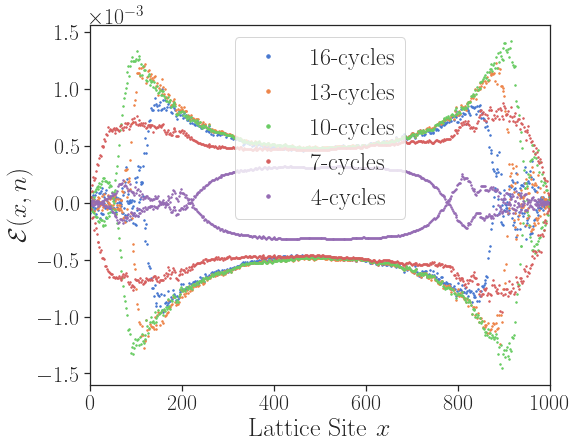

In [84]:
EnergyDensityCorrect2(1000,17,0.2,0.8,False)

(1000, 1000)
(17, 999)


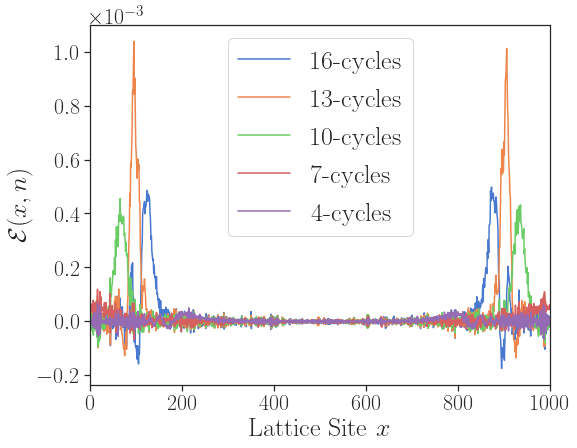

In [246]:
EnergyDensityCorrect(1000,17,0.2,0.8,True)

(1000, 1000)
(18, 999)


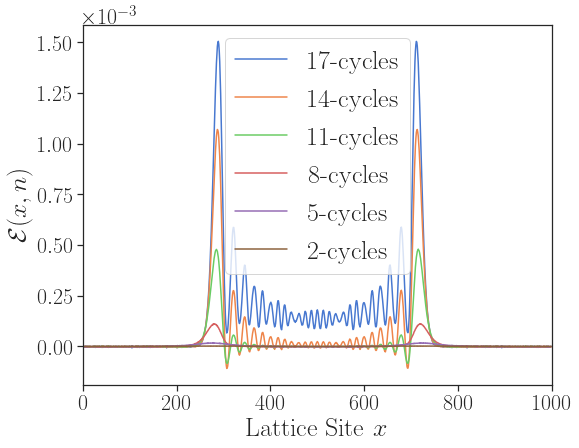

In [88]:
EnergyDensityCorrect(1000,18,0.95,0.05, True)

(1000, 1000)
(18, 999)


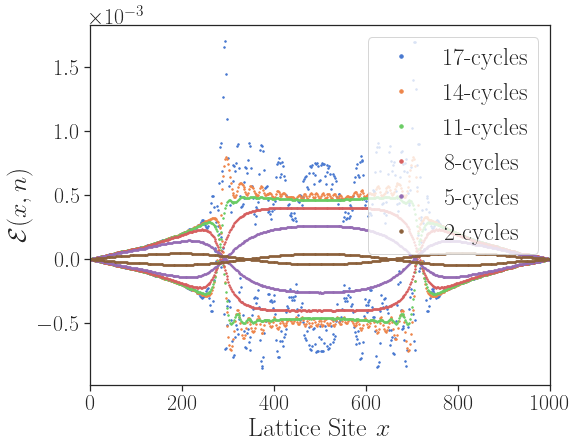

In [245]:
EnergyDensityCorrect2(1000,18,0.95,0.05, False)

(1000, 1000)
(50, 999)


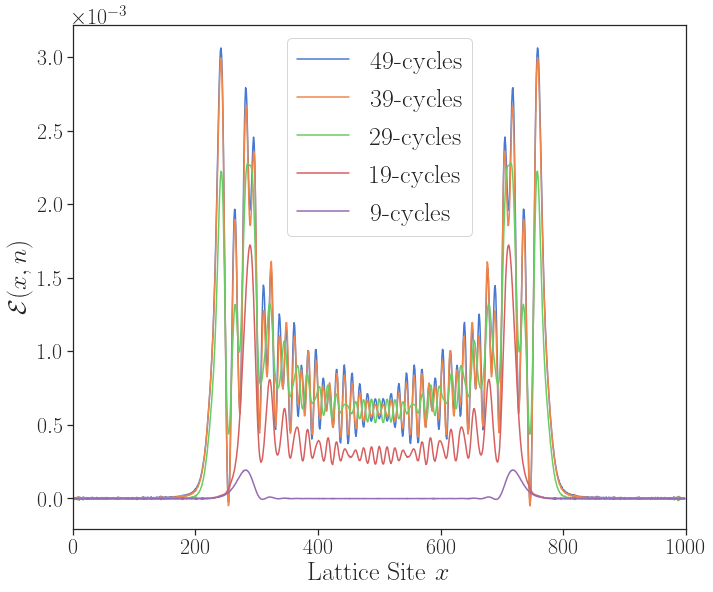

In [57]:
EnergyDensityCorrect2(1000,50,0.95,0.05, True)

(1000, 1000)
(18, 999)


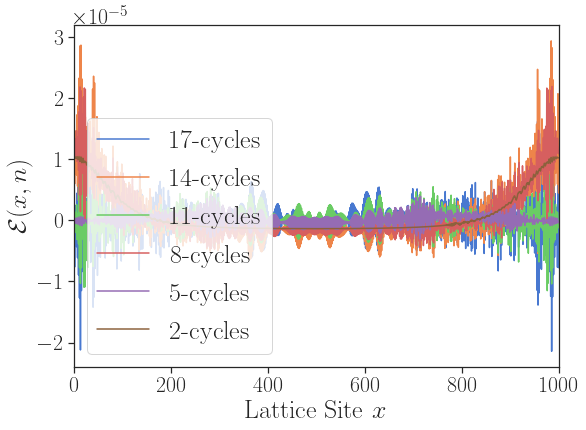

In [10]:
EnergyDensityCorrect(1000,18,0.1, 0.1, True)

(1000, 1000)
(10, 999)


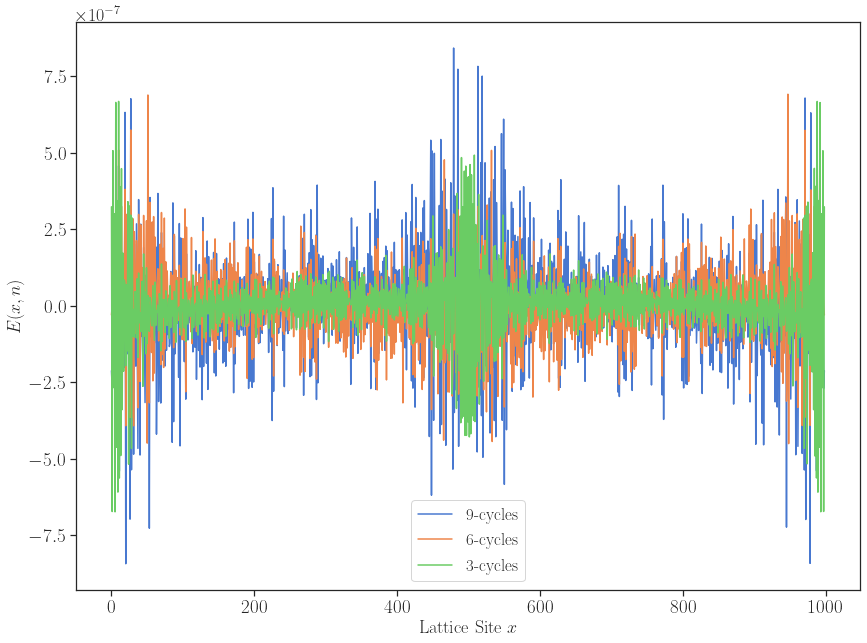

In [9]:
EnergyDensityCorrect(1000,10,0.5, 0.01, True )

In [10]:
def EnergyDensityCorrect1(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        E_density.append([1/2*(state[i, i+1] + state[i+1, i]) 
                              for i in range(L-1)])
    E_density = np.real(np.array(E_density))
    
    return E_density

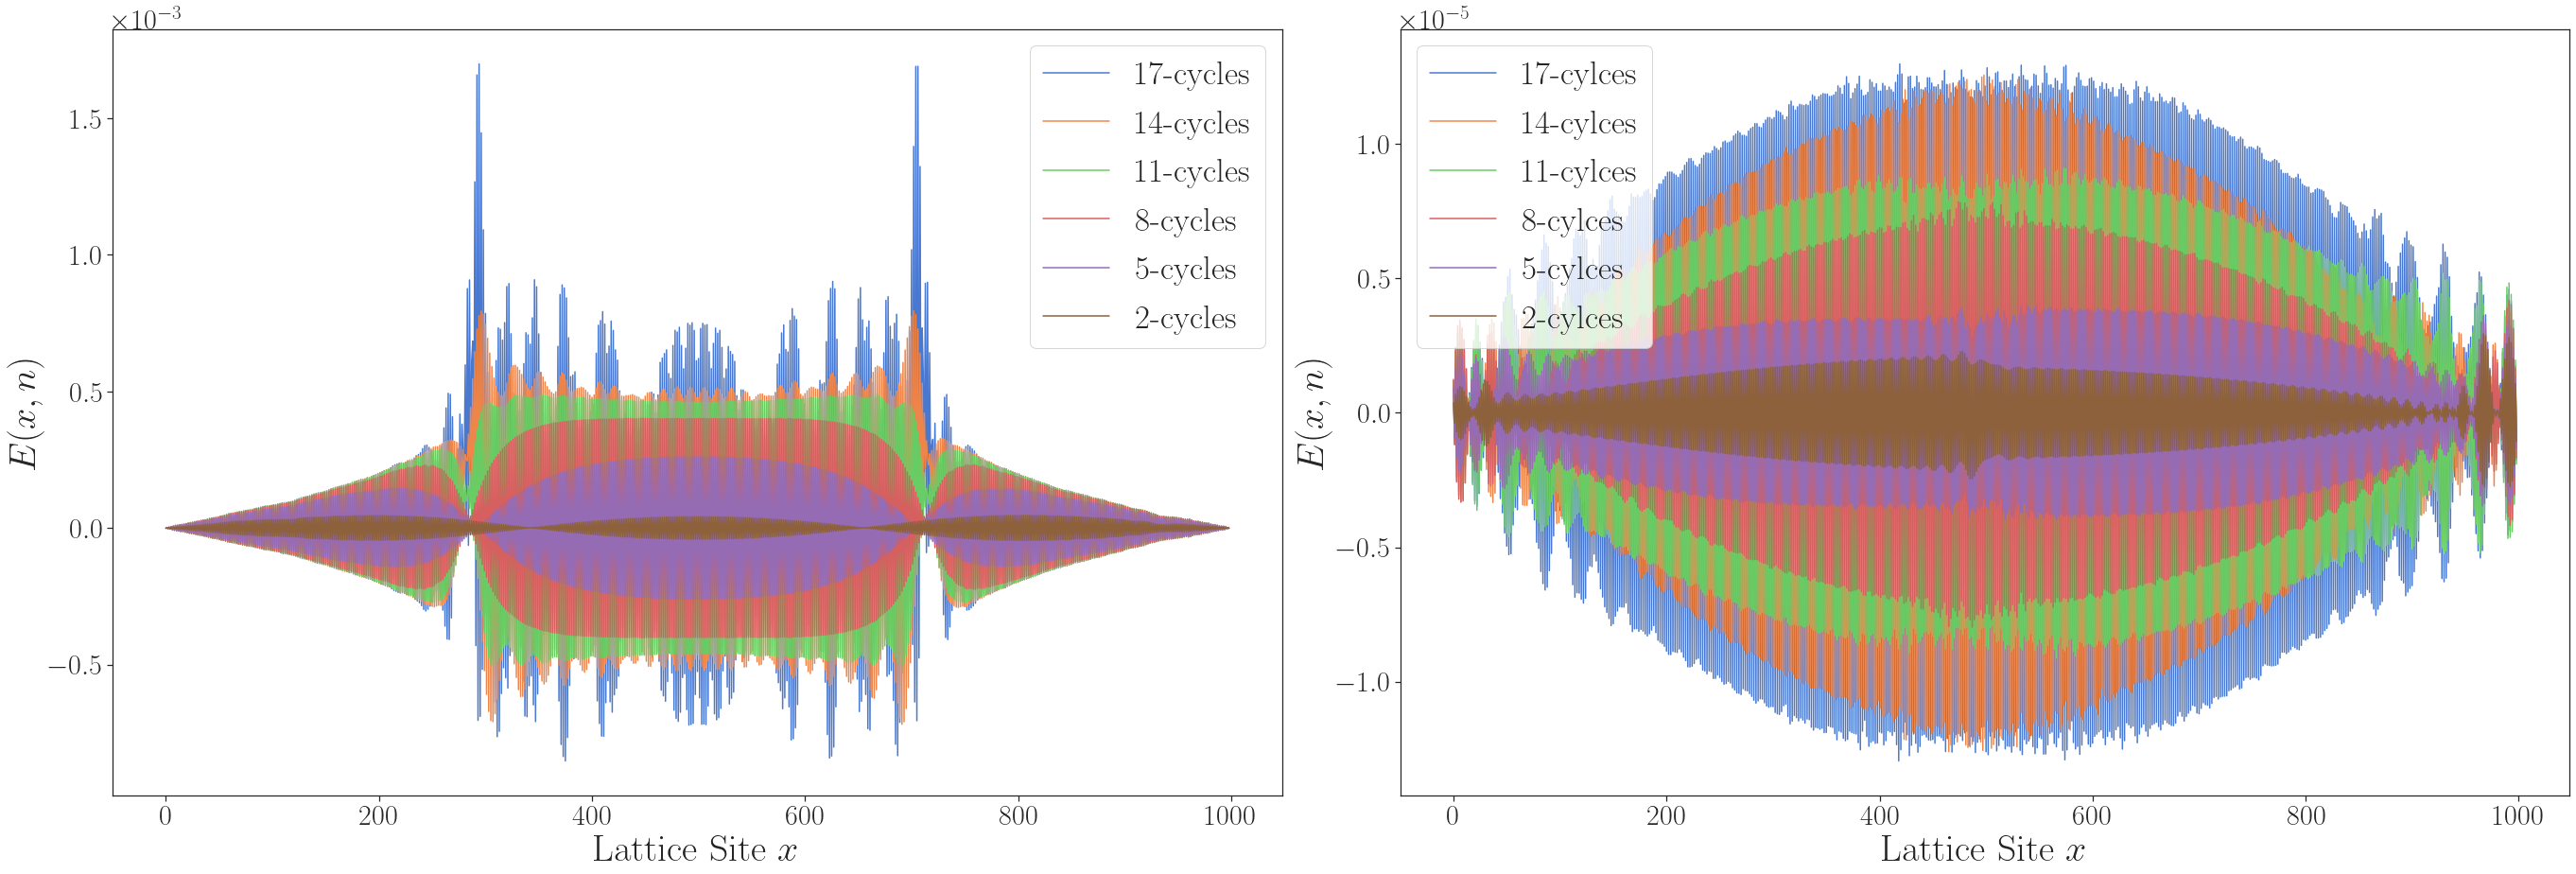

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(38,13))
#fig.suptitle('Heating and non-heating Phase')
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=5)
cycles1=18
cycles2=18
j=1
t=1


while j in range(cycles1-1):
    E_density = EnergyDensityCorrect1(1000,cycles1,0.95,0.05, False)
    ax1.plot(E_density[cycles1 - j] - E_density[0], label="{}-cycles".format(cycles1-j))
    j += 3

while t in range(cycles2-1):
    E_density1 = EnergyDensityCorrect1(1000,cycles2,0.5, 0.01, False)
    ax2.plot(E_density1[cycles2-t] - E_density1[0],label="{}-cylces".format(cycles2-t))
    t += 3
    
ax1.set_xlabel(r'Lattice Site $x$', fontsize = 40)
ax1.set_ylabel(r'$E(x,n)$',fontsize = 40)
ax2.set_xlabel(r'Lattice Site $x$', fontsize = 40)
ax2.set_ylabel(r'$E(x,n)$', fontsize =40)
ax1.ticklabel_format(axis='y', scilimits=[0,0])
ax1.tick_params(axis='both', which='major', labelsize=30)
ax2.tick_params(axis='both', which='major', labelsize=30)
t = ax1.yaxis.get_offset_text()
z = ax2.yaxis.get_offset_text()
t.set_size(30)
z.set_size(30)
ax1.legend(fontsize=35)
ax2.legend(fontsize=35)

fig.tight_layout()
plt.savefig('Energy_Density_Combined.pdf',bbox_inches='tight')

In [12]:
def EnergyDensityInSteps(L,n_cycles):
    k = np.array([np.ones(L-1),np.ones(L-1)])
    offset = [-1,1]
    H_0 = diags(k,offset).toarray()
    eigvals0, eigvecs0 = la.eig(H_0)

    # Sorting the eigenvalues and eigenvectors from smallest to largest eigenvalues
    idx0 = eigvals0.argsort()[::1]   
    eigenValues0 = eigvals0[idx0]
    eigenVectors0 = eigvecs0[:,idx0]

    # Computing the Matrix Elements of the Hamiltonian H_1
    H_1 = np.zeros((L,L))
    for n in range(L):
        for m in range(L):
            if m == n+1 :
                H_1[n,m] = np.sin((math.pi)*(n+0.5)/L)**2
    #             H_1[n,m] = np.round((np.sin((math.pi)*(n+0.5)/L)),2)
            if m == n-1:
                H_1[n,m] = np.sin((math.pi)*(n-0.5)/L)**2 
    eigvals1, eigvecs1 = la.eig(H_1)

    # Sorting the eigenvalues and eigenvectors from smallest to largest eigenvalues
    idx1 = eigvals1.argsort()[::1]   
    eigenValues1 = eigvals1[idx1]
    eigenVectors1 = eigvecs1[:,idx1]

    # Check whether the matrix is symmetric
    # print(H_1 - H_1.transpose())

    # Define the unitary transformations
    U = eigenVectors0
    V = eigenVectors1
    V_her = np.conjugate(V.transpose())
    W = np.dot(V_her, U)
    W_her = np.conjugate(W.transpose())

    # Lenghts of the cycles
    T_0 = 0.95*L
    T_1 = 0.05*L

    # Create the imaginary i
    z = complex(0,1)

    # Creating the diagonal matrix for the exponential eigenvalues of H_0
    exponential_eig0 = []
    for i in range(eigenValues0.size):
        exponential_eig0.append(np.exp(-z*eigenValues0[i]* T_0))
    diagonal_eig0 = np.diag(exponential_eig0)

    # # Creating the diagonal matrix for the exponential eigenvalues of H_1
    exponential_eig1 = [] 
    for i in range(eigenValues1.size):
        exponential_eig1.append(np.exp(-z*eigenValues1[i]*T_1))
    diagonal_eig1 = np.diag(exponential_eig1)

    W1_T1 = np.dot(diagonal_eig1, W)
    W0_T0 = np.dot(diagonal_eig0, W_her)
    
    Floquet_cycle = np.dot(W0_T0, W1_T1)
    n_cycles_Energy_array = []
    for n in range(n_cycles):
        Floquet_cycles = np.linalg.matrix_power(Floquet_cycle, n)
        mathcal_W = np.dot(U, Floquet_cycles)
        mathcal_W_her = np.conjugate(mathcal_W.transpose())
        mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
        mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
        Two_Point_Corellation_Matrix = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)
        print(Two_Point_Correlation_Matrix)
        Energy_Density_array = [0] * (L)
        for l in range(L-1):
            I_dont_even_know_anymore[l] = 0.5*Two_Point_Corellation_Matrix[l,l+1] + 0.5*Two_Point_Corellation_Matrix[l+1,l]
            l += 1
        plt.xlim(100, 800)
        plt.ylim(-0.33, -0.29)
        plt.xlabel('Different Chain Lenghts x')
        plt.ylabel('Energy(x,n)')
        plt.scatter([i for i in range(L)], Energy_Density_array,  s=1)
        plt.show()

## Entanglement Entropy 
The Entanglement Entropy depends on the entanglement cut $x$, i.e the chain length
Implementation of Entanglement Entropy

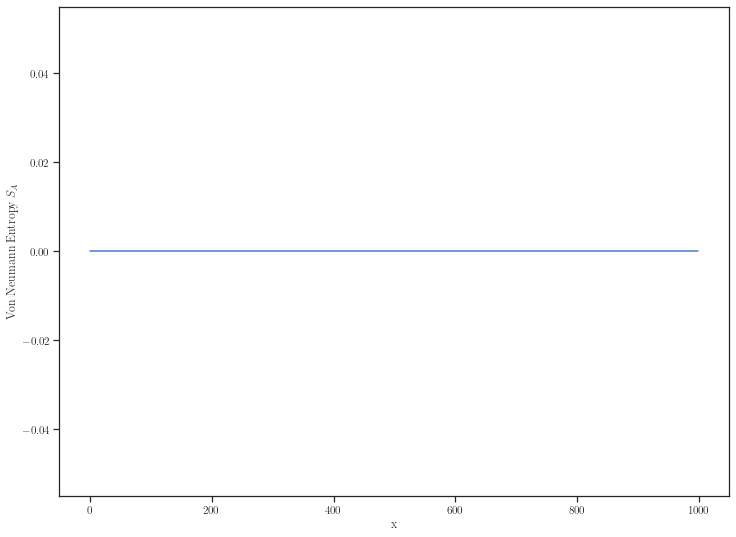

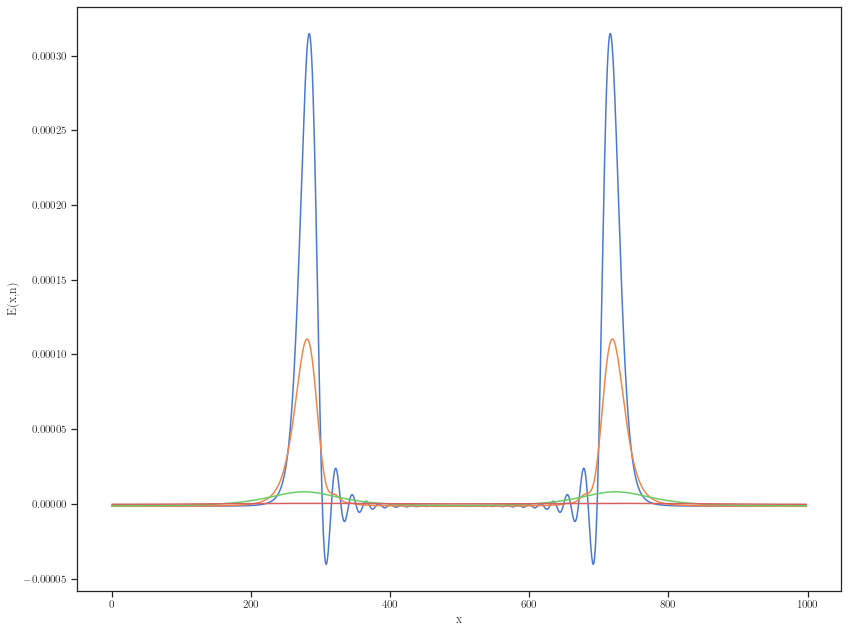

In [13]:
plt.rcParams.update({'font.size': 14})
L = 1000
scale = 1
T0 = 0.95 * L
T1 = 0.05 * L
cycles = 15
pbc = True
def f(x):
    return 2*np.sin(1*np.pi*x/L)*np.sin(1*np.pi*x/L)
def energy(state):
   energy=0
   for i in range(0,L-1):
       energy=state[i,i+1]+state[i+1,i]
   return energy
ham = np.zeros((L, L))
ham_ssd = np.zeros((L, L))
for i in range(L - 1):
    ham[i, i + 1] = -1 / 2
    ham[i + 1, i] = -1 / 2
    ham_ssd[i, i + 1] = -f(i) / 2
    ham_ssd[i + 1, i] = -f(i) / 2
if pbc:
    ham[0, L - 1] = -1 / 2
    ham[L - 1, 0] = -1 / 2
    ham_ssd[0, L - 1] = -f(0) / 2
    ham_ssd[L - 1, 0] = -f(L-1) / 2
vals, U = np.linalg.eigh(ham)
vals_ssd, V = np.linalg.eigh(ham_ssd)
Egs = np.sum(vals[:int(L / 2)])
E0 = np.exp(-1j * T0 * vals)
E1 = np.exp(-1j * T1 * vals_ssd)
E0 = np.matrix(np.diag(E0))
E1 = np.matrix(np.diag(E1))
U = np.matrix(U)
V = np.matrix(V)
W = V.H@U
W1 = E1@W
W0 = E0@(W.H)
Wtotal = W0@W1
Wbar = U
E_density = []



state = Wbar[:, :int(L / 2)]@((Wbar.H)[:int(L / 2), :])

E_density.append([-0.5 * (state[i, i + 1] + state[i + 1, i])
                  for i in range(L - 1)])
for i in range(cycles - 1):
    Wbar = Wbar@Wtotal
    state = Wbar[:, :int(L / 2)]@((Wbar.H)[:int(L / 2), :])
    E_density.append([-0.5 * (state[i, i + 1] + state[i + 1, i])
                      for i in range(L - 1)])
E_density = np.real(np.array(E_density))
a = 0
b = L
w,v = np.linalg.eigh(state[a:b,a:b])
S_a = np.zeros((b,), dtype=float)
epsilon = 10**(-8)
for i in range(b-1):
    if w[i]>epsilon and w[i]<(1-epsilon):
        S_a[i] = S_a[i] - (w[i]*np.log(w[i])) + (1-w[i] * np.log(1-w[i]))
        i += 1
plt.plot(S_a)
plt.xlabel('x')
plt.ylabel('Von Neumann Entropy $S_A$')
plt.show()
plt.plot(E_density[10]-E_density[0])
plt.plot(E_density[8]-E_density[0])
plt.plot(E_density[4]-E_density[0])
plt.plot(E_density[1]-E_density[0])
plt.xlabel('x')
plt.ylabel('E(x,n)')
plt.tight_layout()


In [106]:
def obtainedstate(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
    return state


def entropy(state, a, b, eps=1e-8):
    if a == b:
        return 0
    w, v = np.linalg.eigh(state[a:b, a:b])
    sum = 0
    for i in range(b - a):
        if w[i] > eps and w[i] < (1 - eps):
            sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
    return sum

def entropy_density(state):
    e_d = [entropy(state, 0, x) for x in range(0, L + 1)]
    return e_d

### Entanglement Entropy for heating phase

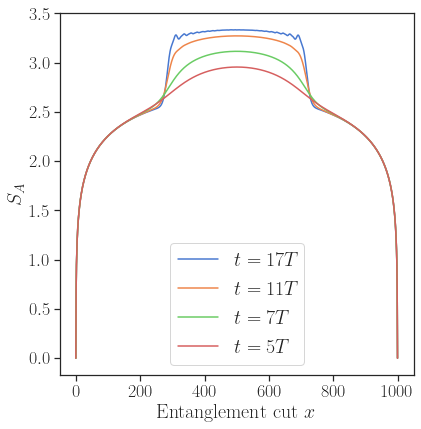

In [108]:
L = 1000 

# entropy(state,0, 1000)
sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (6,6)})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})   
fontSize = 20
ticksize = 18


state1 = obtainedstate(1000,17,0.95, 0.05, True)
state2 = obtainedstate(1000,11,0.95, 0.05, True)
state3 = obtainedstate(1000,7,0.95, 0.05, True)
state4 = obtainedstate(1000,5, 0.95, 0.05, True)

x1 = entropy_density(state1)
x2 = entropy_density(state2)
x3 = entropy_density(state3)
x4 = entropy_density(state4)
text = plt.gca().yaxis.get_offset_text()
text.set_size(18)
    
plt.xlabel(r'Entanglement cut $x$', fontsize = fontSize)
plt.ylabel(r'$S_A$',fontsize = fontSize)
# plt.xticks(fontsize=ticksize)
# plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.ticklabel_format(axis='y', scilimits=[0,0])
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.plot(x1, label=r'$t =17T$')
plt.plot(x2, label=r'$t =11T$')
plt.plot(x3, label=r'$t =7T$')
plt.plot(x4, label=r'$t = 5T$')
plt.legend(fontsize = fontSize)
plt.savefig('Entanglement_Entropy.pdf',bbox_inches='tight')

In [540]:
def entropy(state, a, b, eps=1e-8):
    if a == b:
        return 0
    w, v = np.linalg.eigh(state[a:b, a:b])
    sum = 0
    for i in range(b - a):
        if w[i] > eps and w[i] < (1 - eps):
            sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
    return sum


def entropyeigenvalues(state, a, b, eps=1e-8):
    if a == b:
        return 0
    w, v = np.linalg.eigh(state[a:b, a:b])
    print(np.size(w))
    print(w[:350])
# def mutual_information(state, a_1, a_2, b_1, b_2):
#     return entropy(state, a_1, a_2) + entropy(state, b_1, b_2) - entropy(state, a_2 - a_1, b_2 - b_1)


# def mutual_information_density(state, L, eps=1e-8):
#     total_entrop = entropy(state, list(range(0, L)))
#     e_d = [
#         entropy(state, list(range(0, x)))
#         + entropy(state, list(range(x, L)))
#         - total_entrop
#         for x in range(0, L + 1)
#     ]
#     return e_d

state1 = obtainedstate(1000,17,0.95, 0.05, True)
state2 = obtainedstate(1000,5,0.95, 0.05, True)

entropyeigenvalues(state1, 0, 500)
entropyeigenvalues(state2, 0, 500)

# a2_array = [i for i in range(0, 800)]
# Mutual_information = []*len(a2_array)
# for i in a2_array:
#     Mutual_information.append(mutual_information(state1, 0, i, 1000, i))

# plt.plot(a2_array, Mutual_information)



500
[-1.35635702e-15 -1.25710351e-15 -1.21109851e-15 -1.08367195e-15
 -1.06890934e-15 -1.04153325e-15 -1.02199503e-15 -1.01183154e-15
 -9.99181234e-16 -9.84478097e-16 -9.78921681e-16 -9.73377518e-16
 -9.57382690e-16 -9.46866179e-16 -9.44473492e-16 -9.13319040e-16
 -8.96435507e-16 -8.59334894e-16 -7.89972490e-16 -7.46599895e-16
 -7.41372138e-16 -7.40309670e-16 -7.30653318e-16 -7.26922301e-16
 -7.15716356e-16 -6.88121360e-16 -6.57167274e-16 -6.36319709e-16
 -6.31564654e-16 -6.13335359e-16 -6.11925285e-16 -5.98661493e-16
 -5.93711637e-16 -5.64160361e-16 -5.42057547e-16 -5.41194525e-16
 -5.39108305e-16 -5.37045062e-16 -5.30849241e-16 -5.30607266e-16
 -5.29633249e-16 -5.21991561e-16 -5.19290851e-16 -4.86929532e-16
 -4.83113033e-16 -4.81475294e-16 -4.72210704e-16 -4.71988279e-16
 -4.70542683e-16 -4.50266028e-16 -4.49903261e-16 -4.01318743e-16
 -3.98802282e-16 -3.84375843e-16 -3.76909056e-16 -3.67887673e-16
 -3.44696467e-16 -3.37212895e-16 -3.15131577e-16 -3.13930675e-16
 -2.97699846e-16 -2.8

### Growth of Entanglement Entropy as a function of cycles

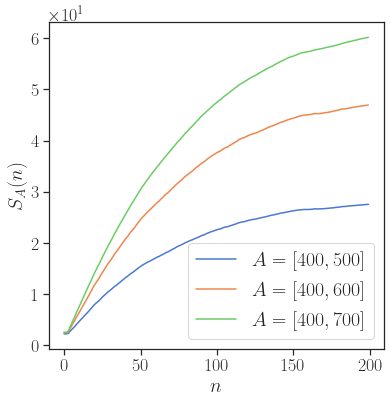

In [6]:
def obtainedstate(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
    return state

# state1 = obtainedstate(1000,17,0.95, 0.05, True)
# state2 = obtainedstate(1000,11,0.95, 0.05, True)
# state3 = obtainedstate(1000,7,0.95, 0.05, True)
# state4 = obtainedstate(1000,5, 0.95, 0.05, True)

def entropy(state, a, b, eps=1e-8):
    if a == b:
        return 0
    w, v = np.linalg.eigh(state[a:b, a:b])
    sum = 0
    for i in range(b - a):
        if w[i] > eps and w[i] < (1 - eps):
            sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
    return sum

L = 1000
# T0 = 0.9
# T1 = 0.9
cycles1 = 200

def entropy_cycles(L, T0, T1, cycles1, cutoff):
    def entropy(state, a, b, eps=1e-8):
        if a == b:
            return 0
        w, v = np.linalg.eigh(state[a:b, a:b])
        sum = 0
        for i in range(b - a):
            if w[i] > eps and w[i] < (1 - eps):
                sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
        return sum
    
    def obtainedstate(L,cycles,T_0, T_1, pbc):
        T_0 = T_0 * L
        T_1 = T_1 * L
        def F(x):
            return 2*np.sin(np.pi*x/L)**2

        def energy(state):
            energy = 0
            for i in range(0, L-1):
                energy = state[i, i+1] + state[i+1, i]
            return energy
        H_0 = np.zeros((L,L))
        H_1 = np.zeros((L,L))
        for i in range(L-1):
            H_0[i, i+1] = 1/2
            H_0[i+1,i] = 1/2
            H_1[i, i+1] = F(i)/2
            H_1[i+1,i] = F(i)/2
        if pbc == True:
            H_0[0,L-1] = 1/2
            H_0[L-1,0] = 1/2
            H_1[0,L-1] = F(0)/2
            H_1[L-1,0] = F(L)/2
        eigenvalues0, U = np.linalg.eigh(H_0)
        eigenvalues1, V = np.linalg.eigh(H_1)
        U = np.matrix(U)
        V = np.matrix(V)

        exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
        exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
        exponential_E0 = np.matrix(np.diag(exponential_E0))
        exponential_E1 = np.matrix(np.diag(exponential_E1))

        W = V.H@U
        mathcalW = U
        W1_T1 = exponential_E1@W
        W0_T0 = exponential_E0@(W.H)
        W_total = W0_T0@W1_T1
        E_density = []
        state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
        E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                          for i in range(L-1)])
        for i in range(cycles - 1):
            mathcalW = mathcalW@W_total
            state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        return state
    Entropy = [None]*cycles1
    for i in range(0,cycles1):
        state = obtainedstate(L,i, T0, T1, True)
        Entropy[i] = entropy(state, 0, cutoff)
        Entropy[i] = Entropy[i]
    return Entropy

#Cutoff center  chain
def entropy_cycles2(L, T0, T1, cycles1, cutoff):
    def entropy(state, a, b, eps=1e-8):
        if a == b:
            return 0
        w, v = np.linalg.eigh(state[a:b, a:b])
        sum = 0
        for i in range(b - a):
            if w[i] > eps and w[i] < (1 - eps):
                sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
        return sum
    
    def obtainedstate(L,cycles,T_0, T_1, pbc):
        T_0 = T_0 * L
        T_1 = T_1 * L
        def F(x):
            return 2*np.sin(np.pi*x/L)**2

        def energy(state):
            energy = 0
            for i in range(0, L-1):
                energy = state[i, i+1] + state[i+1, i]
            return energy
        H_0 = np.zeros((L,L))
        H_1 = np.zeros((L,L))
        for i in range(L-1):
            H_0[i, i+1] = 1/2
            H_0[i+1,i] = 1/2
            H_1[i, i+1] = F(i)/2
            H_1[i+1,i] = F(i)/2
        if pbc == True:
            H_0[0,L-1] = 1/2
            H_0[L-1,0] = 1/2
            H_1[0,L-1] = F(0)/2
            H_1[L-1,0] = F(L)/2
        eigenvalues0, U = np.linalg.eigh(H_0)
        eigenvalues1, V = np.linalg.eigh(H_1)
        U = np.matrix(U)
        V = np.matrix(V)

        exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
        exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
        exponential_E0 = np.matrix(np.diag(exponential_E0))
        exponential_E1 = np.matrix(np.diag(exponential_E1))

        W = V.H@U
        mathcalW = U
        W1_T1 = exponential_E1@W
        W0_T0 = exponential_E0@(W.H)
        W_total = W0_T0@W1_T1
        E_density = []
        state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
        E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                          for i in range(L-1)])
        for i in range(cycles - 1):
            mathcalW = mathcalW@W_total
            state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        return state
    Entropy = [None]*cycles1
    for i in range(0,cycles1):
        state = obtainedstate(L,i, T0, T1, True)
        Entropy[i] = entropy(state, 400, cutoff)
        Entropy[i] = Entropy[i]
    return Entropy

sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (6,6)})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})   

fontSize = 20
ticksize = 18

text = plt.gca().yaxis.get_offset_text()
text.set_size(18)
cycles_arr = [i for i in range(0,cycles1)]
# L_array = [50,100,200,300]

# cutoff_array = [int(0.5*L), int(0.2*L), int(0.1*L)]
cutoff_array2 = [int(0.5*L), int(0.6*L), int(0.7*L)]
# L_array = [500,700,900,1000]


for j in cutoff_array2:
    markerstyle = '-'
    plt.plot(cycles_arr, entropy_cycles2(L, 0.9, 0.9, cycles1, j), markerstyle, label = r'$A = [400,{}]$'.format(j))
#     plt.plot(cycles_arr, entropy_cycles(L, 20/L, 20/L, cycles1, j), markerstyle, label = r'$A = [0,{}]$'.format(j))
#     plt.plot(cycles_arr, entropy_cycles(L, 0.01, 0.04, cycles1, j), markerstyle, label = r'$A = [0,{}]$'.format(j))
    
plt.ylabel(r'$S_A(n)$', fontsize = fontSize)
plt.xlabel(r'$n$',fontsize = fontSize)
# plt.xlim(0,cycles1-1)
# plt.xticks(fontsize=ticksize)
# plt.yticks(fontsize=ticksize)
# plt.tight_layout()
plt.ticklabel_format(axis='y', scilimits=[0,0])
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.legend(fontsize = fontSize)
# plt.savefig('Entanglement_EntropyEvolutionCutoff-nonheating.pdf')
plt.savefig('Entanglement_EntropyEvolutionCutoff2.pdf')
plt.show()




# plt.savefig('Entanglement_Entropy.pdf',bbox_inches='tight')

<ipython-input-109-3c77819c50fb>:224: RuntimeWarning: divide by zero encountered in log
  Total_Energy_array[i] = np.log(Energy_array[i])/6
<ipython-input-109-3c77819c50fb>:224: RuntimeWarning: invalid value encountered in cdouble_scalars
  Total_Energy_array[i] = np.log(Energy_array[i])/6
/Users/fabianjaeger/opt/anaconda3/envs/QM/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


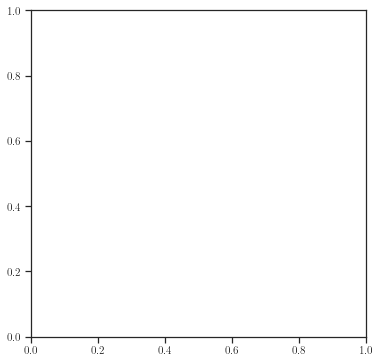

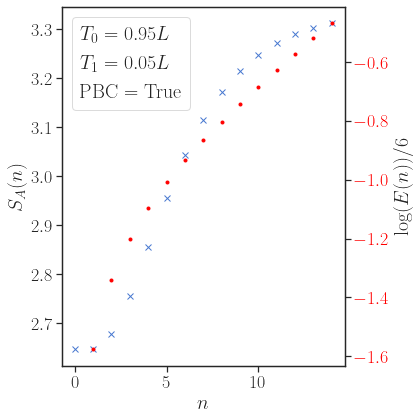

In [109]:
import matplotlib.patches as mpl_patches

def TotalEnergy(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = -1/2
        H_0[i+1,i] = -1/2
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_0[0,L-1] = -1/2
        H_0[L-1,0] = -1/2
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    
    Ground_state =  U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    Ground_State_Energy_H0 = 0
    for i in range(L-1):
        Ground_State_Energy_H0 += 0.5*Ground_state[i,i+1] + 0.5*Ground_state[i+1,i]

    # Energies for n cycles
    n = [i for i in range(cycles)]
    Total_Energy_array = [None] * (len(n))
    for i in range(len(n)):
        Floquet_cycles = np.linalg.matrix_power(W_total, n[i])
        mathcal_W = np.dot(U, Floquet_cycles)
        mathcal_W_her = np.conjugate(mathcal_W.transpose())
        mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
        mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
        state = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)
        Total_Energy = 0
        for l in range(L-1):
            Total_Energy += 0.5*state[l,l+1] + 0.5*state[l+1,l]
        Total_Energy_array[i] = Total_Energy - Ground_State_Energy_H0
    return np.array(Total_Energy_array)

def obtainedstate(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = -1/2
        H_0[i+1,i] = -1/2
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_0[0,L-1] = -1/2
        H_0[L-1,0] = -1/2
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
    return state

# state1 = obtainedstate(1000,17,0.95, 0.05, True)
# state2 = obtainedstate(1000,11,0.95, 0.05, True)
# state3 = obtainedstate(1000,7,0.95, 0.05, True)
# state4 = obtainedstate(1000,5, 0.95, 0.05, True)

def entropy(state, a, b, eps=1e-8):
    if a == b:
        return 0
    w, v = np.linalg.eigh(state[a:b, a:b])
    sum = 0
    for i in range(b - a):
        if w[i] > eps and w[i] < (1 - eps):
            sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
    return sum

def entropy_cycles(L, T0, T1, cycles1, cutoff):
    def entropy(state, a, b, eps=1e-8):
        if a == b:
            return 0
        w, v = np.linalg.eigh(state[a:b, a:b])
        sum = 0
        for i in range(b - a):
            if w[i] > eps and w[i] < (1 - eps):
                sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
        return sum
    
    def obtainedstate(L,cycles,T_0, T_1, pbc):
        T_0 = T_0 * L
        T_1 = T_1 * L
        def F(x):
            return 2*np.sin(np.pi*x/L)**2

        def energy(state):
            energy = 0
            for i in range(0, L-1):
                energy = state[i, i+1] + state[i+1, i]
            return energy
        H_0 = np.zeros((L,L))
        H_1 = np.zeros((L,L))
        for i in range(L-1):
            H_0[i, i+1] = -1/2
            H_0[i+1,i] = -1/2
            H_1[i, i+1] = -F(i)/2
            H_1[i+1,i] = -F(i)/2
        if pbc == True:
            H_0[0,L-1] = -1/2
            H_0[L-1,0] = -1/2
            H_1[0,L-1] = -F(0)/2
            H_1[L-1,0] = -F(L)/2
        eigenvalues0, U = np.linalg.eigh(H_0)
        eigenvalues1, V = np.linalg.eigh(H_1)
        U = np.matrix(U)
        V = np.matrix(V)

        exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
        exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
        exponential_E0 = np.matrix(np.diag(exponential_E0))
        exponential_E1 = np.matrix(np.diag(exponential_E1))

        W = V.H@U
        mathcalW = U
        W1_T1 = exponential_E1@W
        W0_T0 = exponential_E0@(W.H)
        W_total = W0_T0@W1_T1
        state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
        for i in range(cycles - 1):
            mathcalW = mathcalW@W_total
            state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        return state
    Entropy = [None]*cycles1
    for i in range(0,cycles1):
        state = obtainedstate(L,i, T0, T1, True)
        Entropy[i] = entropy(state, 0, cutoff)
        Entropy[i] = Entropy[i]
    return Entropy

sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (6,6)})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})   

fontSize = 20
ticksize = 18

L = 1000
cycles1 = 15
T0 = 0.95
T1 = 0.05

text = plt.gca().yaxis.get_offset_text()
text.set_size(18)
# cycles_arr = [i for i in range(0,cycles1)]
# L_array = [50,100,200,300]

# cutoff_array = [int(0.5*L), int(0.2*L), int(0.1*L)]
# L_array = [500,700,900,1000]

markerstyle = '-'
# plt.plot(cycles_arr, entropy_cycles(L, 0.9, 0.9, cycles1, int(L/2)), markerstyle, label = r'$A = [0,{}]$'.format(j))




# state1 = obtainedstate(L,cycles1,T0, T1, True)

# print(entropy_cycles(L, T0, T1, cycles1))

Entropy_array = [None]*cycles1
Total_Energy_array = [None]*cycles1

for i in range(cycles1):
    Entropy_array[i] = np.exp(6*entropy_cycles(L, T0, T1, cycles1, int(L/2))[i])

    
for i in range(cycles1):
#     print(TotalEnergy(L,cycles1,0.9, 0.9,True)[i])
    Energy_array = TotalEnergy(L,cycles1,T0, T1,True)
    Total_Energy_array[i] = np.log(Energy_array[i])/6
    
# print(Entropy_array)
# print(TotalEnergy(L,cycles1,T_0, T_1,True))
n1 = [i for i in range(cycles1)]
# fig, ax1 = plt.subplots(1,1, figsize = (6,6))

fontSize = 20
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax2 = ax1.twinx()

ax1.plot(n1, entropy_cycles(L, T0, T1, cycles1, int(L/2)), 'x', label = 'Entropy')
ax2.plot(n1, Total_Energy_array, '.', color = 'r', label = 'Total Energy')


# ax1.plot(n1, Entropy_array, 'x', label = 'Entanglement Entropy')
# ax2.plot(n1, TotalEnergy(L,cycles1,T0, T1,True), '.', label = 'Total Energy', color = 'r')

# ax1.plot(n1, entropy_cycles(L, T0, T1, cycles1), 'x')
ax1.set_xlabel(r'$n$', fontsize = fontSize)
ax1.set_ylabel(r'$S_A(n)$', fontsize = fontSize)
ax1.tick_params(axis='both', which='major', labelsize=ticksize)
ax2.tick_params(axis='both', which='major', labelsize=ticksize)
ax2.set_ylabel(r'$\log(E(n))/6$', fontsize = fontSize)

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                             lw=0, alpha=0)] * 3

labels = []
labels.append(r"$T_0 = {}L$".format(T0))
labels.append(r"$T_1 = {}L$".format(T1))
labels.append(r"PBC = {True}")

leg = ax1.legend(handles, labels, loc='upper left', fontsize=fontSize, 
      fancybox=True, framealpha=0.7, 
      handlelength=0, handletextpad=0)


for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
# for tl in ax1.get_yticklabels():
#     tl.set_color('b')
    
# plt.legend(fontsize = fontSize)


plt.tight_layout()
plt.savefig('Entanglement_Entropy_relation.pdf')
plt.show()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/fabianjaeger/opt/anaconda3/envs/QM/lib/python3.8/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-477-b51d9f5c3cf6>", line 79, in <module>
    mutual_information.append(mutual_information_density(obtainedstate(L,j, 0.9, 0.2,True), L)[i]-mutual_information_ground[i])
  File "<ipython-input-477-b51d9f5c3cf6>", line 61, in mutual_information_density
    e_d = [
  File "<ipython-input-477-b51d9f5c3cf6>", line 62, in <listcomp>
    entropy(state, list(range(0, x)))
  File "<ipython-input-477-b51d9f5c3cf6>", line 48, in entropy
    w, v = np.linalg.eigh(state[subset][:, subset])
  File "<__array_function__ internals>", line 5, in eigh
  File "/Users/fabianjaeger/opt/anaconda3/envs/QM/lib/python3.8/site-packages/numpy/linalg/linalg.py", line 1471, in eigh
    w, vt = gufunc(a, signature=signature, extobj=extobj)
KeyboardInterrupt

During handlin

TypeError: object of type 'NoneType' has no len()

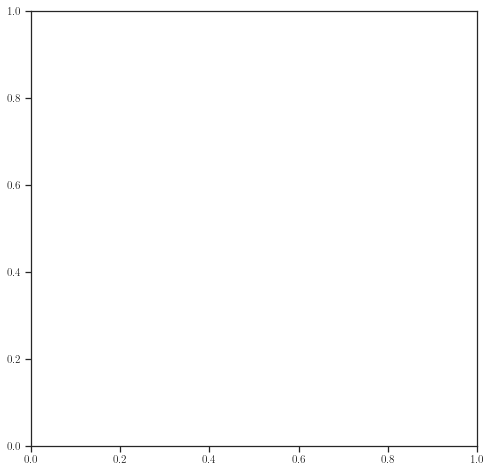

In [477]:
fontSize = 20

def obtainedstate(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = -1/2
        H_0[i+1,i] = -1/2
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_0[0,L-1] = -1/2
        H_0[L-1,0] = -1/2
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
    return state


def entropy(state, subset, eps=1e-8):
    if len(subset) == 0:
        return 0
    w, v = np.linalg.eigh(state[subset][:, subset])
    e_sum = 0
    for i in range(len(subset)):
        if w[i] > eps and w[i] < (1 - eps):
            e_sum = e_sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
    return e_sum

def entropy_density(c_state, L):
    e_d = [entropy(c_state, list(range(x))) for x in range(0, L + 1)]
    return e_d

def mutual_information_density(state, L, eps=1e-8):
    total_entrop = entropy(state, list(range(0, L)))
    e_d = [
        entropy(state, list(range(0, x)))
        + entropy(state, list(range(x, L)))
        - total_entrop
        for x in range(0, L + 1)
    ]
    return e_d

L = 1000
x = [i for i in range(0,L)]
cycles = [2,5,8,12,20]

fig, ax1 = plt.subplots(1,1, figsize = (8,8))

mutual_information_ground = mutual_information_density(obtainedstate(L,0,0.9,0.2,True), L)
for j in cycles:
    mutual_information = []
    for i in range(0,L):
        mutual_information.append(mutual_information_density(obtainedstate(L,j, 0.9, 0.2,True), L)[i]-mutual_information_ground[i])
    ax1.plot(x, mutual_information, label = r'$n={}$'.format(j))


ax1.plot(x,mutual_information)
ax1.set_xlabel(r'Lattice Site $x$', fontsize = fontSize)
ax1.set_ylabel(r'$S_A(n) - S_A(0)$',fontsize = fontSize)
ax1.ticklabel_format(axis='y', scilimits=[0,0])
tx = ax1.yaxis.get_offset_text()
tx.set_fontsize(fontSize)
ax1.tick_params(axis='both', which='major', labelsize=fontSize)
ax1.legend(fontsize = fontSize)
plt.savefig('Entanglement_Entropy_subtraction.pdf',bchbox_inches='tight')
plt.show()


### Entanglement Entropy for non-heating phase

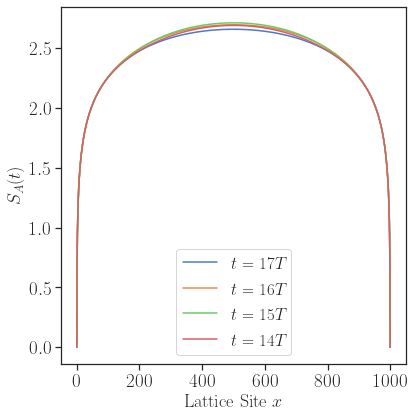

In [240]:
T_0 = 0.05
T_1 = 0.05
cycles = [17, 16, 15, 14]

groundstate = obtainedstate(1000, 0, T_0, T_1, True)
state1 = obtainedstate(1000,cycles[0],T_0, T_1, True)
state2 = obtainedstate(1000,cycles[1],T_0, T_1, True)
state3 = obtainedstate(1000,cycles[2],T_0, T_1, True)
state4 = obtainedstate(1000,cycles[3],T_0, T_1, True)


def entropy_density2(state, L):
    e_d = [entropy(state, 0, x) for x in range(0, L + 1)]
    return e_d

def entropy(state, a, b, eps=1e-8):
    if a == b:
        return 0
    w, v = np.linalg.eigh(state[a:b, a:b])
    sum = 0
    for i in range(b - a):
        if w[i] > eps and w[i] < (1 - eps):
            sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
    return sum

# state2 = obtainedstate(1000,cycles[1],T_0, T_1, True)
# state3 = obtainedstate(1000,cycles[2], T_0, T_1, True)

#[x1 - x2 for (x1, x2) in zip(List1, List2)]

# x1 = [z1 - z2 for (z1, z2) in zip(entropy_density2(state1, 1000),entropy_density2(groundstate, 1000))]
# x2 = [z1 - z2 for (z1, z2) in zip(entropy_density2(state2, 1000),entropy_density2(groundstate, 1000))]
# x3 = [z1 - z2 for (z1, z2) in zip(entropy_density2(state3, 1000),entropy_density2(groundstate, 1000))]
# x4 = [z1 - z2 for (z1, z2) in zip(entropy_density2(state4, 1000),entropy_density2(groundstate, 1000))]


x1 = entropy_density2(state1, 1000)
x2 = entropy_density2(state2, 1000)
x3 = entropy_density2(state3, 1000)
x4 = entropy_density2(state4, 1000)


#x4 = entropy_density2(state4, 300)
#x5 = entropy_density2(state2, 500)
# x2 = entropy_density(state2)
# x3 = entropy_density(state3)
text = plt.gca().yaxis.get_offset_text()
text.set_size(18)
    
plt.xlabel(r'Lattice Site $x$', fontsize = 18)
#plt.ylabel(r'$S_A(t) - S_A(0)$',fontsize = 18)
plt.ylabel(r'$S_A(t)$',fontsize = 18)
plt.tight_layout()
plt.ticklabel_format(axis='y', scilimits=[0,0])
plt.tick_params(axis='both', which='major', labelsize=19)
plt.plot(x1, label=r'$t = {}T$'.format(cycles[0]))
plt.plot(x2, label=r'$t = {}T$'.format(cycles[1]))
plt.plot(x3, label=r'$t = {}T$'.format(cycles[2]))
plt.plot(x4, label=r'$t = {}T$'.format(cycles[3]))
#plt.plot(x5, label=r'$L = 500$')
#plt.plot(x4, label=r'$L = 300$')
# plt.plot(x2, label=r'$t =11T$')
# plt.plot(x3, label=r'$t =5T$')
plt.legend(fontsize = 17)
plt.savefig('Entanglement_Entropy_thermal1.pdf',bbox_inches='tight')

### Entanglement Entropy, Total Energy correspondence

<ipython-input-416-b85f87332cce>:160: RuntimeWarning: divide by zero encountered in log
  Total_Energy_array[i] = np.log(TotalEnergy(L,cycles1,T0, T1,True)[i])/6
<ipython-input-416-b85f87332cce>:160: RuntimeWarning: invalid value encountered in cdouble_scalars
  Total_Energy_array[i] = np.log(TotalEnergy(L,cycles1,T0, T1,True)[i])/6


NameError: name 'PBC' is not defined

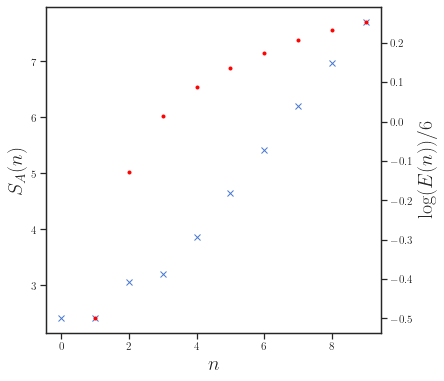

In [416]:
import matplotlib.patches as mpl_patches

def TotalEnergy(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        E_density.append([1/2*(state[i, i+1] + state[i+1, i]) 
                              for i in range(L-1)])
    E_density = np.real(np.array(E_density))

    
    Ground_state =  U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    Ground_State_Energy_H0 = 0
    for i in range(L-1):
        Ground_State_Energy_H0 += 0.5*Ground_state[i,i+1] + 0.5*Ground_state[i+1,i]

    # Energies for n cycles
    n = [i for i in range(cycles)]
    Total_Energy_array = [None] * (len(n))
    for i in range(len(n)):
        Floquet_cycles = np.linalg.matrix_power(W_total, n[i])
        mathcal_W = np.dot(U, Floquet_cycles)
        mathcal_W_her = np.conjugate(mathcal_W.transpose())
        mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
        mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
        state = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)
        Total_Energy = 0
        for l in range(L-1):
            Total_Energy += 0.5*state[l,l+1] + 0.5*state[l+1,l]
        Total_Energy_array[i] = Total_Energy - Ground_State_Energy_H0
        Total_Energy_array = np.real(np.array(Total_Energy_array))
    return Total_Energy_array


def obtainedstate(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
    return state


def entropy(state, a, b, eps=1e-8):
    if a == b:
        return 0
    w, v = np.linalg.eigh(state[a:b, a:b])
    sum = 0
    for i in range(b - a):
        if w[i] > eps and w[i] < (1 - eps):
            sum = sum - (w[i] * np.log(w[i]) + (1 - w[i]) * np.log(1 - w[i]))
    return sum

def entropy_cycles(L, T0, T1, cycles):
    Entropy = [None]*cycles
    cutoff = int(L/2)
    for i in range(0,cycles):
        state = obtainedstate(L,i, T0, T1, True)
        Entropy[i] = entropy(state, 0, cutoff)
        Entropy[i] = Entropy[i]
    return Entropy

L = 500
cycles1 = 10
T0 = 0.9
T1 = 0.9

# state1 = obtainedstate(L,cycles1,T0, T1, True)

# print(entropy_cycles(L, T0, T1, cycles1))

Entropy_array = [None]*cycles1
Total_Energy_array = [None]*cycles1

for i in range(cycles1):
    Entropy_array[i] = np.exp(6*entropy_cycles(L, T0, T1, cycles1)[i])

    
for i in range(cycles1):
    Total_Energy_array[i] = np.log(TotalEnergy(L,cycles1,T0, T1,True)[i])/6
    
# print(Entropy_array)
# print(TotalEnergy(L,cycles1,T_0, T_1,True))
n1 = [i for i in range(cycles1)]
# fig, ax1 = plt.subplots(1,1, figsize = (6,6))

fontSize = 20
fig, ax1 = plt.subplots(1,1, figsize = (6,6))
ax2 = ax1.twinx()

ax1.plot(n1, entropy_cycles(L, T0, T1, cycles1), 'x', label = 'Entropy')
ax2.plot(n1, Total_Energy_array, '.', color = 'r', label = 'Total Energy')

# ax1.plot(n1, Entropy_array, 'x', label = 'Entanglement Entropy')
# ax2.plot(n1, TotalEnergy(L,cycles1,T_0, T_1,True), '.', label = 'Total Energy', color = 'r')


# ax1.plot(n1, entropy_cycles(L, T0, T1, cycles1), 'x')
ax1.set_xlabel(r'$n$', fontsize = fontSize)
ax1.set_ylabel(r'$S_A(n)$', fontsize = fontSize)
ax2.set_ylabel(r'$\log(E(n))/6$', fontsize = fontSize)


handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                             lw=0, alpha=0)] * 3

labels = []
labels.append(r"$T_0 = {}L$".format(T0))
labels.append(r"$T_1 = {}L$".format(T1))
labels.append(r"PBC = {}".format(PBC))

leg = ax1.legend(handles, labels, loc='upper left', fontsize=fontSize, 
      fancybox=True, framealpha=0.7, 
      handlelength=0, handletextpad=0)


for tl in ax2.get_yticklabels():
    tl.set_color('r')
    
# for tl in ax1.get_yticklabels():
#     tl.set_color('b')
    
# plt.legend(fontsize = fontSize)
plt.show()

No handles with labels found to put in legend.


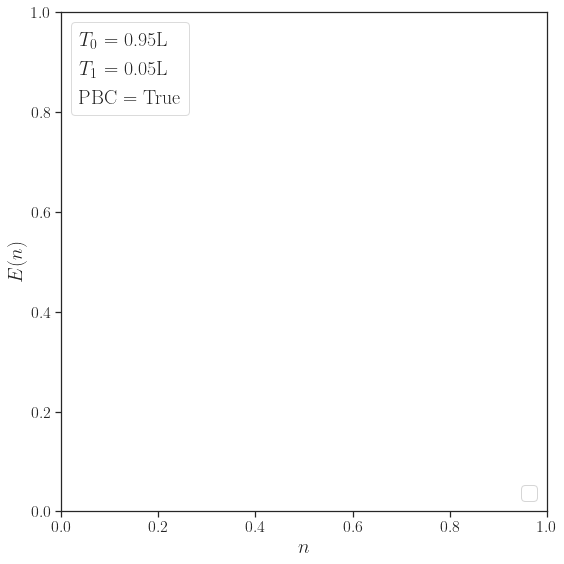

In [213]:
import matplotlib.patches as mpl_patches

def TotalEnergy(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    T_0 = int(T_0)
    T_1 = int(T_1)
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        E_density.append([1/2*(state[i, i+1] + state[i+1, i]) 
                              for i in range(L-1)])
    E_density = np.real(np.array(E_density))

    
    Ground_state =  U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    Ground_State_Energy_H0 = 0
    for i in range(L-1):
        Ground_State_Energy_H0 += 0.5*Ground_state[i,i+1] + 0.5*Ground_state[i+1,i]

    # Energies for n cycles
    n = [i for i in range(cycles)]
    Total_Energy_array = [None] * (len(n))
    for i in range(len(n)):
        Floquet_cycles = np.linalg.matrix_power(W_total, n[i])
        mathcal_W = np.dot(U, Floquet_cycles)
        mathcal_W_her = np.conjugate(mathcal_W.transpose())
        mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
        mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
        state = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)
        Total_Energy = 0
        for l in range(L-1):
            Total_Energy += 0.5*state[l,l+1] + 0.5*state[l+1,l]
        Total_Energy_array[i] = Total_Energy - Ground_State_Energy_H0
        Total_Energy_array = np.real(np.array(Total_Energy_array))
    return Total_Energy_array
            
    
fontSize = 20
ticksize = 16
    
    
cycles1 = 150
cycles2 = 34

plt.rc('xtick',labelsize=ticksize)
plt.rc('ytick',labelsize=ticksize)

def TotalEnergyHeating(L,cycles1,T_0, T_1, PBC):
    n1 = [i for i in range(cycles1)]
    fig, ax1 = plt.subplots(1,1, figsize = (6,6))
    ax1.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), '.', linewidth = 1)
#     ax1.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), '--', linewidth = 1, color = 'grey')
#     ax1.plot(TotalEnergy(L,cycles1,T_0-0.2, T_1, PBC), 'o', linewidth = 1)
#     ax1.plot(TotalEnergy(L,cycles1,-0.05, 0.05, PBC), 'o', linewidth = 1)
    
#     ax1.text(0.1, 0.11, r"$T_0$ = {}L".format(T_0), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.12, r"$T_1$ = {}L".format(T_1), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.13, r"$L$ = {}".format(L), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.14, r"PBC = {}".format(PBC), color = "black", fontsize=fontSize)
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
#     ax1.xaxis.set_ticks(np.arange(0,cycles1,2))
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 4

    labels = []
    labels.append(r"$T_0$ = {}L".format(T_0))
    labels.append(r"$T_1$ = {}L".format(T_1))
    labels.append(r"$L$ = {}".format(L))
    labels.append(r"PBC = {}".format(PBC))

    ax1.legend(handles, labels, loc='best', fontsize=fontSize, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
    
    ax1.set_ylabel(r"$E(n)$",fontsize = fontSize)
    ax1.set_xlabel(r"$n$", fontsize=fontSize)
    
    ax1.yaxis.set_major_formatter(formatter) 
    tx = ax1.yaxis.get_offset_text()
    tx.set_fontsize(20)
    plt.savefig('TotalEnergyHeating.pdf')
    plt.tight_layout()
    plt.show()
    
    
def TotalEnergyNonHeating(L,cycles1,T_0, T_1, PBC):
    n2 = [i for i in range(cycles2)]
    fig, ax2 = plt.subplots(1,1, figsize = (6,6))
    ax2.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), 'o', linewidth = 1)
    ax2.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), '--', linewidth = 1, color = 'grey')
    
#     ax2.text(-1, 0.004, r"$T_0$ = {}L".format(T_0), color="black", fontsize=fontSize)
#     ax2.text(-1, 0.0042, r"$T_1$ = {}L".format(T_1), color="black", fontsize=fontSize)
#     ax2.text(-1, 0.0044, r"$L$ = {}".format(L), color="black", fontsize=fontSize)
#     ax2.text(-1, 0.0046, r"PBC = {}".format(PBC), color = "black", fontsize=fontSize)

    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
#     ax2.xaxis.set_ticks(np.arange(0,cycles1,2))
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)

    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 4

    labels = []
    labels.append(r"$T_0$ = {}L".format(T_0))
    labels.append(r"$T_1$ = {}L".format(T_1))
    labels.append(r"$L$ = {}".format(L))
    labels.append(r"PBC = {}".format(PBC))

    ax2.legend(handles, labels, loc='best', fontsize=fontSize, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
    
    ax2.yaxis.set_major_formatter(formatter) 
    tx = ax2.yaxis.get_offset_text()
    tx.set_fontsize(20)
    
    
    ax2.set_ylabel(r"$E(n)$", fontsize = fontSize)
    ax2.set_xlabel(r"$n$", fontsize=fontSize)
    plt.savefig('TotalEnergyNonHeating.pdf')
    plt.tight_layout()
    plt.show()

    
    
# 
# TotalEnergyHeating(1000,cycles1,0.95,0.05, True) 


# TotalEnergyNonHeating(1000,cycles2,0.01,0.04, True)
# TotalEnergyHeating(1000,cycles1,0.95,0.05, True)
#Subplot
fig, ax1 = plt.subplots(1, figsize = (8, 8))



T_0 = 0.95
T_1 =0.05
PBC = True


# ax1.plot(TotalEnergy(200,cycles1,T_0, T_1, PBC), '.', linewidth = 1, label = r'$L=200$')
# ax1.plot(TotalEnergy(300,cycles1,T_0, T_1, PBC), '.', linewidth = 1, label = r'$L=300$')
# ax1.plot(TotalEnergy(1000,cycles1,T_0, T_1, PBC), '.', linewidth=1, label = r'$L=1000$')
#     ax1.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), '--', linewidth = 1, color = 'grey')
#     ax1.plot(TotalEnergy(L,cycles1,T_0-0.2, T_1, PBC), 'o', linewidth = 1)
#     ax1.plot(TotalEnergy(L,cycles1,-0.05, 0.05, PBC), 'o', linewidth = 1)

#     ax1.text(0.1, 0.11, r"$T_0$ = {}L".format(T_0), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.12, r"$T_1$ = {}L".format(T_1), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.13, r"$L$ = {}".format(L), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.14, r"PBC = {}".format(PBC), color = "black", fontsize=fontSize)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
#     ax1.xaxis.set_ticks(np.arange(0,cycles1,2))
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                             lw=0, alpha=0)] * 3

labels = []
labels.append(r"$T_0$ = {}L".format(T_0))
labels.append(r"$T_1$ = {}L".format(T_1))
labels.append(r"PBC = {}".format(PBC))

leg = ax1.legend(handles, labels, loc='upper left', fontsize=fontSize, 
      fancybox=True, framealpha=0.7, 
      handlelength=0, handletextpad=0)


ax1.set_ylabel(r"$E(n)$",fontsize = fontSize)
ax1.set_xlabel(r"$n$", fontsize=fontSize)

ax1.yaxis.set_major_formatter(formatter) 
tx = ax1.yaxis.get_offset_text()
tx.set_fontsize(20)


ax1.legend(fontsize = fontSize, loc = 'lower right')
ax1.add_artist(leg)
    

plt.savefig('TotalEnergyHeating.pdf')
plt.tight_layout()
plt.show()




# fig, ax1 = plt.subplots(1,1)

# ax1.set_xlim(0,cycles1)
# ax1.set_ylim(0,0.15)


# ax1.scatter(n1, TotalEnergy(L,cycles1,T_0, T_1, PBC))
# ax1.scatter(n2, TotalEnergy(L,cycles2,T_0, T_1 , PBC))

# ax1.set_title(r"Heating Phase",fontsize=25)
# ax2.set_title(r"Non-heating phase",fontsize=25)

# 
#     ax.text(0, 0.1, r"$T_0$ = {}".format(T_0),
#         color="black", fontsize=24,
#         horizontalalignment="center", verticalalignment="center",
#         bbox=dict(boxstyle="round", fc="white", ec="black", pad=0.2))


# ax1.xaxis.set_ticks(np.arange(0,cycles2, 5))


# ax1.text(-1, 0.00007, r"$T_0$ = {}L".format(T_0), color="black", fontsize=25)
# ax1.text(-1, 0.000075, r"$T_1$ = {}L".format(T_1), color="black", fontsize=25)
# ax1.text(-1, 0.00008, r"$L$ = {}".format(L), color="black", fontsize=25)
# ax1.text(-1, 0.000085, r"PBC = {}".format(PBC), color = "black", fontsize=25)

#     red_patch = mpatches.Patch(color='red', label='The red data')
#     blue_patch = mpatches.Patch(color='blue', label='The blue data')

#     ax.legend(handles=[red_patch, blue_patch])




#LABELS


# ax2.set_ylabel(r"Total Energy",fontsize = 25)


# ax.grid(False)
# plt.tight_layout()
# plt.savefig('Total_Energy1d_heating.pdf')
# plt.show()

(0.003928866558925294+0j)
(276.3057846128351j, -276.3057846128351j)


/Users/fabianjaeger/opt/anaconda3/envs/QM/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


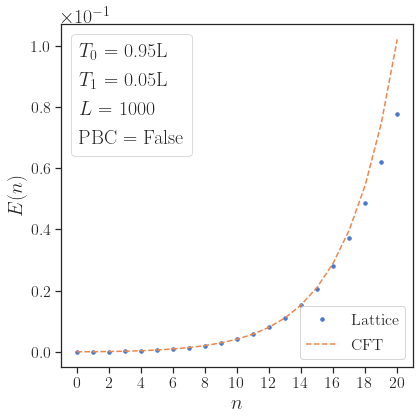

In [224]:
def EnergyCFT(L, n, T_0, T_1):
    i = complex(0,1)

    tau0 = i*T_0
    tau1 = i*T_1

    a = (1 + (np.pi*tau1)/L)*np.exp(np.pi*tau0/L)
    b = -(np.pi*tau1*np.exp(-np.pi*tau0/L))/L
    c = np.pi*tau1/L*np.exp(np.pi*tau0/L)
    d = (1 - (np.pi*tau1)/L)*np.exp(-np.pi*tau0/L)

    gamma1 = (a - d - np.sqrt((a-d)**2 + 4*b*c))/(2*c)
    gamma2 = (a - d + np.sqrt((a-d)**2 + 4*b*c))/(2*c)

    eta = (a + d + np.sqrt((a-d)**2 + 4*b*c))/(a + d - np.sqrt((a-d)**2 + 4*b*c))


    A = gamma1 - eta**n*gamma2
    B = (eta**n - 1)*gamma1*gamma2
    C = 1 - eta**n
    D = gamma1*eta**n - gamma2
    
    frac = (A*D + B*C)/(A*D-B*C)
    Energy = 2*np.pi*frac/(16*L)

    return Energy


print(EnergyCFT(100, 10, 0.95, 0.05))


def ChiralPeaksLocation(L, n, T_0, T_1):
    i = complex(0,1)

    tau0 = i*T_0
    tau1 = i*T_1

    a = (1 + (np.pi*tau1)/L)*np.exp(np.pi*tau0/L)
    b = -(np.pi*tau1*np.exp(-np.pi*tau0/L))/L
    c = np.pi*tau1/L*np.exp(np.pi*tau0/L)
    d = (1 - (np.pi*tau1)/L)*np.exp(-np.pi*tau0/L)

    gamma1 = (a - d - np.sqrt((a-d)**2 + 4*b*c))/(2*c)
    gamma2 = (a - d + np.sqrt((a-d)**2 + 4*b*c))/(2*c)

    eta = (a + d + np.sqrt((a-d)**2 + 4*b*c))/(a + d - np.sqrt((a-d)**2 + 4*b*c))


    A = gamma1 - eta**n*gamma2
    B = (eta**n - 1)*gamma1*gamma2
    C = 1 - eta**n
    D = gamma1*eta**n - gamma2
    
    x_peak1 = L*np.log(gamma2)/(2*np.pi)
    x_peak2 = L*np.log(np.conjugate(gamma2))/(2*np.pi)
    return(x_peak1, x_peak2)
    
print(ChiralPeaksLocation(1000, 12, 0.95*L, 0.05*L))
# fig, ax1 = plt.subplots(1, figsize = (8, 8))
    
# fontSize = 20
# ticksize = 16


# L = 1000
# T_0 = 0.95*L
# T_1 = 0.05*L
# cycles = 16

# formatter = ticker.ScalarFormatter(useMathText=True)
# formatter.set_scientific(True) 
# formatter.set_powerlimits((-1,1)) 
# #     ax1.xaxis.set_ticks(np.arange(0,cycles1,2))
# plt.xticks(fontsize=ticksize)
# plt.yticks(fontsize=ticksize)

# handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
#                              lw=0, alpha=0)] * 4

# labels = []
# labels.append(r"$T_0$ = {}L".format(T_0))
# labels.append(r"$T_1$ = {}L".format(T_1))
# labels.append(r"$L$ = {}".format(L))
# labels.append(r"PBC = {}".format(PBC))

# ax1.legend(handles, labels, loc='best', fontsize=fontSize, 
#       fancybox=True, framealpha=0.7, 
#       handlelength=0, handletextpad=0)

# ax1.set_ylabel(r"$E(n)$",fontsize = fontSize)
# ax1.set_xlabel(r"$n$", fontsize=fontSize)

# ax1.yaxis.set_major_formatter(formatter) 
# tx = ax1.yaxis.get_offset_text()
# tx.set_fontsize(20)

# ax1.plot(EnergyCFT_array, '--')
# plt.show()



def TotalEnergyCFTHeating(L,cycles1,T_0, T_1, PBC):
    EnergyCFT_array = [None]*cycles1
    cycles = [i for i in range(cycles1)]
    for i in cycles:
        EnergyCFT_array[i] = EnergyCFT(L, i, T_0*L, T_1*L) - 0.0004

    fig, ax1 = plt.subplots(1,1, figsize = (6,6))
    ax1.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), '.', markersize= 7, label = 'Lattice')
    ax1.plot(EnergyCFT_array, '--', label = 'CFT')
#     ax1.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), '--', linewidth = 1, color = 'grey')
#     ax1.plot(TotalEnergy(L,cycles1,T_0-0.2, T_1, PBC), 'o', linewidth = 1)
#     ax1.plot(TotalEnergy(L,cycles1,-0.05, 0.05, PBC), 'o', linewidth = 1)
    
#     ax1.text(0.1, 0.11, r"$T_0$ = {}L".format(T_0), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.12, r"$T_1$ = {}L".format(T_1), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.13, r"$L$ = {}".format(L), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.14, r"PBC = {}".format(PBC), color = "black", fontsize=fontSize)
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
#     ax1.xaxis.set_ticks(np.arange(0,cycles1,2))
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 4

    labels = []
    labels.append(r"$T_0$ = {}L".format(T_0))
    labels.append(r"$T_1$ = {}L".format(T_1))
    labels.append(r"$L$ = {}".format(L))
    labels.append(r"PBC = {}".format(PBC))

    leg2 = ax1.legend(handles, labels, loc='best', fontsize=fontSize, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
    
    leg1 = ax1.legend(fontsize=fontSize-4, loc = 'lower right')

    
    ticks = [0,2,4,6,8,10,12,14,16,18,20]
    ax1.add_artist(leg2)
    ax1.set_ylabel(r"$E(n)$",fontsize = fontSize)
    ax1.set_xlabel(r"$n$", fontsize=fontSize)
    ax1.set_xticks(ticks, minor=False)
    
    ax1.yaxis.set_major_formatter(formatter) 
    tx = ax1.yaxis.get_offset_text()
    tx.set_fontsize(20)
    plt.savefig('TotalEnergyHeating.pdf')
    plt.tight_layout()
    plt.show()
TotalEnergyCFTHeating(1000, 21, 0.95, 0.05, False)

/Users/fabianjaeger/opt/anaconda3/envs/QM/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


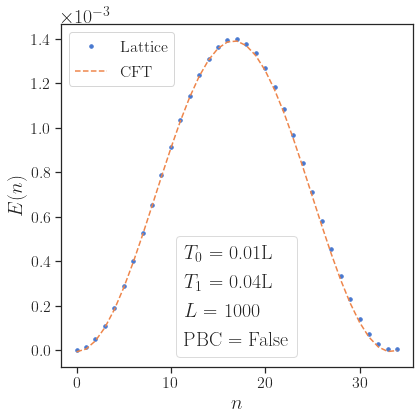

In [218]:
def TotalEnergyCFTNonHeating(L,cycles1,T_0, T_1, PBC):
    EnergyCFT_array = [None]*cycles1
    cycles = [i for i in range(cycles1)]
    for i in cycles:
        EnergyCFT_array[i] = EnergyCFT(L, i, T_0*L, T_1*L)-0.0004

    fig, ax1 = plt.subplots(1,1, figsize = (6,6))
    ax1.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), '.', markersize= 7, label = 'Lattice')
    ax1.plot(EnergyCFT_array, '--', label = 'CFT')
#     ax1.plot(TotalEnergy(L,cycles1,T_0, T_1, PBC), '--', linewidth = 1, color = 'grey')
#     ax1.plot(TotalEnergy(L,cycles1,T_0-0.2, T_1, PBC), 'o', linewidth = 1)
#     ax1.plot(TotalEnergy(L,cycles1,-0.05, 0.05, PBC), 'o', linewidth = 1)
    
#     ax1.text(0.1, 0.11, r"$T_0$ = {}L".format(T_0), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.12, r"$T_1$ = {}L".format(T_1), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.13, r"$L$ = {}".format(L), color="black", fontsize=fontSize)
#     ax1.text(0.1, 0.14, r"PBC = {}".format(PBC), color = "black", fontsize=fontSize)
    
    formatter = ticker.ScalarFormatter(useMathText=True)
    formatter.set_scientific(True) 
    formatter.set_powerlimits((-1,1)) 
#     ax1.xaxis.set_ticks(np.arange(0,cycles1,2))
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    
    handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
                                 lw=0, alpha=0)] * 4

    labels = []
    labels.append(r"$T_0$ = {}L".format(T_0))
    labels.append(r"$T_1$ = {}L".format(T_1))
    labels.append(r"$L$ = {}".format(L))
    labels.append(r"PBC = {}".format(PBC))

    leg2 = ax1.legend(handles, labels, loc='best', fontsize=fontSize, 
          fancybox=True, framealpha=0.7, 
          handlelength=0, handletextpad=0)
    
    leg1 = ax1.legend(fontsize=fontSize-4, loc = 'upper left')

    ax1.add_artist(leg2)
    ax1.set_ylabel(r"$E(n)$",fontsize = fontSize)
    ax1.set_xlabel(r"$n$", fontsize=fontSize)
    
    ax1.yaxis.set_major_formatter(formatter) 
    tx = ax1.yaxis.get_offset_text()
    tx.set_fontsize(20)
    plt.savefig('TotalEnergyNonHeating.pdf')
    plt.tight_layout()
    plt.show()
TotalEnergyCFTNonHeating(1000,35,0.01, 0.04, False)

<ipython-input-29-dbf4cc7f1510>:83: ComplexWarning: Casting complex values to real discards the imaginary part
  TotalEnergymatrix[j,i] = TotalEnergy(L,cycles,T0[i], T1[j], True)


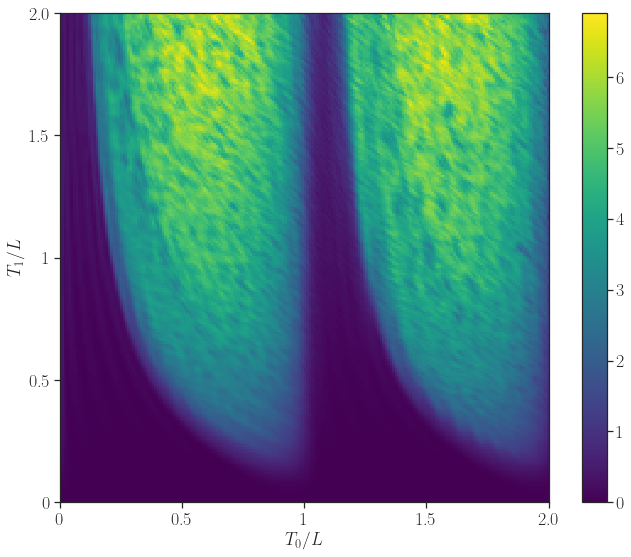

In [29]:
fontSize = 18
ticksize = 18
def TotalEnergy(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    T_0 = int(T_0)
    T_1 = int(T_1)
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    
    def energy(state):
        energy = 0
        for i in range(0, L-1):
            energy = state[i, i+1] + state[i+1, i]
        return energy
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                      for i in range(L-1)])
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
        E_density.append([1/2*(state[i, i+1] + state[i+1, i]) 
                              for i in range(L-1)])
    E_density = np.real(np.array(E_density))

    
    Ground_state =  U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    Ground_State_Energy_H0 = 0
    for i in range(L-1):
        Ground_State_Energy_H0 += 0.5*Ground_state[i,i+1] + 0.5*Ground_state[i+1,i]

    # Energies for n cycles
#     n = [i for i in range(cycles)
    Floquet_cycles = np.linalg.matrix_power(W_total, cycles)
    mathcal_W = np.dot(U, Floquet_cycles)
    mathcal_W_her = np.conjugate(mathcal_W.transpose())
    mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
    mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
    state = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)
    Total_Energy = 0
    for l in range(L-1):
        Total_Energy += 0.5*state[l,l+1] + 0.5*state[l+1,l]
    Total_Energy = Total_Energy - Ground_State_Energy_H0
    return Total_Energy

nm = 200
T0 = np.linspace(0, 2, num=nm)
T1 = np.linspace(0, 2, num=nm)

cycles = 6
L = 100
TotalEnergymatrix = np.zeros((len(T0), len(T1)), dtype = float)
for i in range(0, len(T0)):
    for j in  range(0, len(T1)):
        TotalEnergymatrix[j,i] = TotalEnergy(L,cycles,T0[i], T1[j], True)

# plt.imshow(TotalEnergymatrix, cmap='viridis', interpolation = 'bilinear')
plt.imshow(TotalEnergymatrix, cmap='viridis', interpolation = 'nearest')
plt.xlim(0, len(T0))
plt.ylim(0, len(T1))
clb = plt.colorbar()
clb.ax.tick_params(labelsize=ticksize) 

# clb = plt.colorbar()
# clb.ax.set_title('Total Energy')

# np.where(arr == 15)
# x = [0, 0.5, 1, 1.5 ,2]
# x = [0.0, np.where(T0 == 0.5), np.where(T0 == 1.0), np.where(T0 == 1.5), np.where(T0 == 2.0)]
# x = [0.0, len(T0)/2, len(T0)]
# y = [0.0, len(T1)/2, len(T1)]
x = [0, 50, 100, 150, 200]
# labels = ['high', 'low', 37337]
# label = ['0', '0.5', '1', '1.5', '2']

# label = ['0', '1', '2']
label = ['0', '0.5', '1', '1.5', '2.0']

plt.xticks(x, label)
plt.yticks(x, label)

plt.xlabel(r'$T_0/L$', fontsize = fontSize)
plt.ylabel(r'$T_1/L$',fontsize = fontSize)

plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)

# plt.xticks([0, ])
# plt.yticks([0, 1])

plt.savefig('PhaseDiagram.pdf')
plt.show()


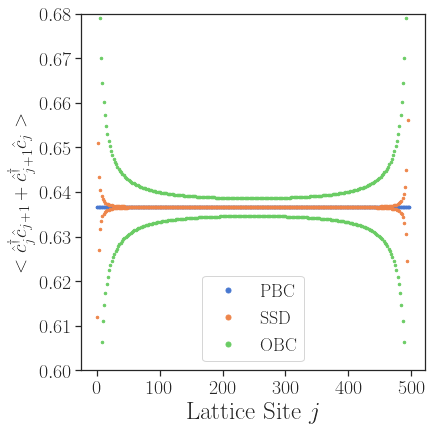

In [33]:
sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (6,6)})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})
L =500
fontSize = 20
ticksize = 18
def averageEnergyDensityH0(L, pbc):
    H_0 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = -1/2
        H_0[i+1,i] = -1/2
    if pbc == True:
        H_0[0,L-1] = -1/2
        H_0[L-1,0] = -1/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    U = np.matrix(U)
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
#     state = V[:,:int(L/2)]@((V.H)[:int(L/2),:])
    E_density.append([(state[i,i+1] + state[i+1, i])
                          for i in range(L-1)])
    diag_E_density = [E_density[0][i] for i in range(0,L-1)]
    return diag_E_density

def averageEnergyDensitySSD(L,pbc):
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues1, V = np.linalg.eigh(H_1)
    V = np.matrix(V)
    E_density = []
#     state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    state = V[:,:int(L/2)]@((V.H)[:int(L/2),:])
    E_density.append([(state[i,i+1] + state[i+1, i])
                          for i in range(L-1)])
    diag_E_density = [E_density[0][i] for i in range(0,L-1)]
    return diag_E_density

# diag_state = [state[i,i] for i in range(0,L)]
Markersize = 5
fill = 'full'
plt.xlabel(r'Lattice Site $j$', fontsize = 25)
plt.ylabel(r'$<\hat{c}_j^\dagger \hat{c}_{j+1} + \hat{c}_{j+1}^\dagger \hat{c}_j>$',fontsize = fontSize)
plt.tight_layout()
plt.plot(averageEnergyDensityH0(L,True)[1:L-1],'.', label = 'PBC', fillstyle=fill, markersize = Markersize)
plt.plot(averageEnergyDensitySSD(L ,False)[2:L-1], '.',label = 'SSD', fillstyle=fill, markersize = Markersize)
plt.plot(averageEnergyDensityH0(L,False)[1:L-1],'.', label = 'OBC', fillstyle=fill, markersize = Markersize)


# plt.plot(averageEnergyDensityH0(L,True)[1:L-1], label = 'PBC', fillstyle=fill)
# plt.plot(averageEnergyDensityH0(L,False)[1:L-1], label = 'OBC', fillstyle=fill)
# plt.plot(averageEnergyDensitySSD(L ,False)[2:L-1],label = 'SSD', fillstyle=fill )




plt.ylim((0.6,0.68 ))
plt.xticks(fontsize=fontSize)
plt.yticks(fontsize=fontSize)
# plt.title("Bond energy at half-filling")
# plt.plot(diag_E_density,  'g^', label = 'OBC')
# plt.plot(diag_E_density, 'bo', label = 'PBC') 
legend = plt.legend(frameon=True)
for legend_handle in legend.legendHandles:
    legend_handle._legmarker.set_markersize(4)
plt.legend(markerscale=2, fontsize = fontSize-2)
plt.savefig('BondEnergy.pdf')
plt.show()

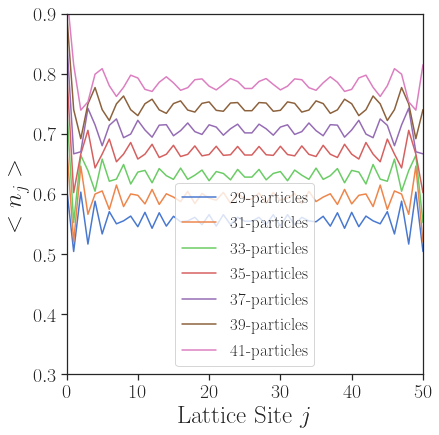

In [99]:
# sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (6,6)})
# plt.rcParams.update({
#     "text.usetex": True,
#     "font.family": "serif",
#     "font.sans-serif": ["Computer Modern Roman"]})    

# Size of figure before was (12,6)

L = 52
particle_numbers = [29, 31, 33, 35, 37, 39, 41]
def averageEnergyDensityH0(L, pbc, nrparticles):
    H_0 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = -1/2
        H_0[i+1,i] = -1/2
    if pbc == True:
        H_0[0,L-1] = -1/2
        H_0[L-1,0] = -1/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    U = np.matrix(U)
    E_density = []
    state = U[:,:nrparticles]@((U.H)[:nrparticles,:])
#     state = V[:,:int(L/2)]@((V.H)[:int(L/2),:])
    E_density.append([state[i,i]
                          for i in range(L-1)])
    diag_E_density = [E_density[0][i] for i in range(0,L-1)]
    return diag_E_density

# def averageEnergyDensitySSD(L,pbc):
#     def F(x):
#         return 2*np.sin(np.pi*x/L)**2
#     H_1 = np.zeros((L,L))
#     for i in range(L-1):
#         H_1[i, i+1] = -F(i)/2
#         H_1[i+1,i] = -F(i)/2
#     if pbc == True:
#         H_1[0,L-1] = -F(0)/2
#         H_1[L-1,0] = -F(L)/2
#     eigenvalues1, V = np.linalg.eigh(H_1)
#     V = np.matrix(V)
#     E_density = []
# #     state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
#     state = V[:,:int(L/2)]@((V.H)[:int(L/2),:])
#     E_density.append([(state[i,i+1] + state[i+1, i])
#                           for i in range(L-1)])
#     diag_E_density = [E_density[0][i] for i in range(0,L-1)]
#     return diag_E_density

# diag_state = [state[i,i] for i in range(0,L)]



for i in range(0, len(particle_numbers)):
    particle_nr = particle_numbers[i]
    plt.plot(averageEnergyDensityH0(L,False, particle_nr)[0 :L-1], label = "{}-particles".format(particle_numbers[i]), fillstyle=fill)
        
        
fill = 'full'
plt.xlabel(r'Lattice Site $j$', fontsize = 25)
plt.ylabel(r'$<n_j>$',fontsize = 25)
plt.tight_layout()
# plt.plot(averageEnergyDensityH0(L,True)[0 :L-1],'bo', label = 'PBC', fillstyle=fill)
# plt.plot(averageEnergyDensityH0(L,False)[1:L-1],'^g', label = 'OBC', fillstyle=fill)
# plt.plot(averageEnergyDensitySSD(L ,False)[2:L-1], 'dr',label = 'SSD', fillstyle=fill )
plt.ylim((0.3,0.9))
plt.xlim(0,L-2)
plt.xticks(fontsize=20)
plt.ticklabel_format(useOffset=False)
plt.yticks(fontsize=20)
# plt.title("Bond energy at half-filling")
# plt.plot(diag_E_density,  'g^', label = 'OBC')
# plt.plot(diag_E_density, 'bo', label = 'PBC') 
plt.legend(fontsize = 17)
plt.savefig('Occupation_number_H0_OBC.pdf')
plt.show()

### Eigenstate Profile Floquet

(0.9999999972217568+0j)
(999,)


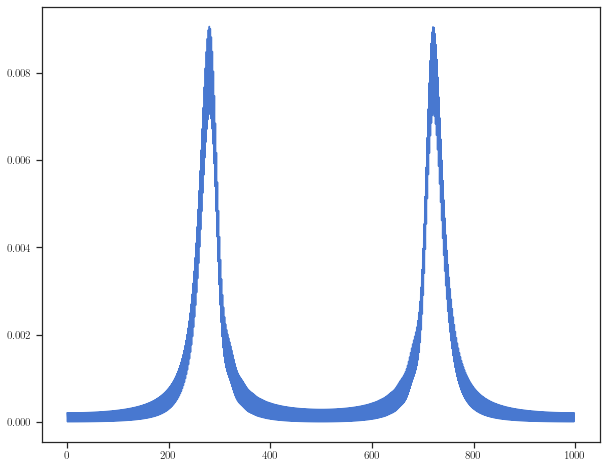

In [255]:
def OccupationNumberFloquet(L,eigenstate_nr,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2

    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,(eigenstate_nr-1):eigenstate_nr]@((U.H)[(eigenstate_nr-1):eigenstate_nr,:])
    
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,(eigenstate_nr-1):eigenstate_nr]@((mathcalW.H)[(eigenstate_nr-1):eigenstate_nr,:])
        E_density.append([state[i,i]
                          for i in range(L-1)])
    diag_E_densitycycles= E_density[cycles-2]
    print(np.sum(diag_E_densitycycles))
    print(np.shape(E_density[cycles-2]))

    
    return diag_E_densitycycles


plt.plot(OccupationNumberFloquet(1000,500,10,0.95, 0.05, True))
plt.show()

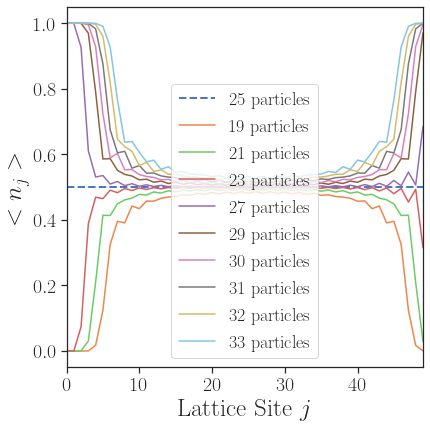

In [96]:
sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (6,6)})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})   


fontSize = 20
ticksize = 18

L = 50
particle_numbers = [19, 21, 23, 27, 29, 30, 31, 32, 33]

def averageEnergyDensitySSD(L,pbc,nrparticles):
    def F(x):
        return 2*np.sin(np.pi*(x - 0.5)/L)**2
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues1, V = np.linalg.eigh(H_1)
    V = np.matrix(V)
    E_density = []
#     state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    state = V[:,:nrparticles]@((V.H)[:nrparticles,:])
    E_density.append([(state[i,i])
                          for i in range(L)])
    diag_E_density = [E_density[0][i] for i in range(0,L)]
    return diag_E_density

plt.plot(averageEnergyDensitySSD(L,True, 25)[0: L], '--', label = "{} particles".format(25), linewidth = 2)
for i in range(0, len(particle_numbers)):
    particle_nr = particle_numbers[i]
    plt.plot(averageEnergyDensitySSD(L,True, particle_nr)[0 :L], label = "{} particles".format(particle_numbers[i]))
    

fill = 'full'
plt.xlabel(r'Lattice Site $j$', fontsize = 25)
plt.ylabel(r'$<n_j>$',fontsize = 25)
plt.tight_layout()
# plt.plot(averageEnergyDensityH0(L,True)[0 :L-1],'bo', label = 'PBC', fillstyle=fill)
# plt.plot(averageEnergyDensityH0(L,False)[1:L-1],'^g', label = 'OBC', fillstyle=fill)
# plt.plot(averageEnergyDensitySSD(L ,False)[2:L-1], 'dr',label = 'SSD', fillstyle=fill )
# plt.ylim((0.3,0.9))
plt.xlim(0,L-1)
# plt.xticks([0,10,20,30,40,49])
plt.xticks(fontsize=fontSize)
plt.ticklabel_format(useOffset=False)
plt.yticks(fontsize=fontSize)
# plt.title("Bond energy at half-filling")
# plt.plot(diag_E_density,  'g^', label = 'OBC')
# plt.plot(diag_E_density, 'bo', label = 'PBC') 
plt.legend(fontsize = ticksize, loc = 'lower center')
plt.savefig('Occupation_number_H1.pdf')
plt.show()

1.0
1.0
1.0000000000000002
1.0000000000000004
1.0000000000000002
1.0000000000000009
0.9999999999999997
1.0000000000000004
0.9999999999999996
1.0


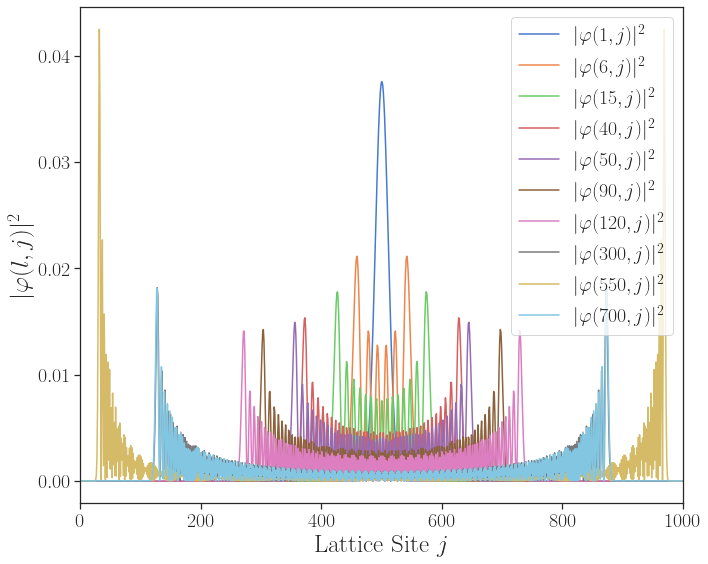

In [229]:
L = 1000
fontSize = 20
ticksize = 18
eigenstate_array = [1,6, 15,  40, 50, 90 ,120, 300, 550, 700]
# eigenstate_array = [2,4,5, 6]
fill = 'full'

def eigenstate_profileSSD(L,pbc,eigenstate_nr:int):
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues1, V = np.linalg.eigh(H_1)
    V = np.matrix(V)
    E_density = []
#     state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    state = V[:,(eigenstate_nr-1):eigenstate_nr]@((V.H)[(eigenstate_nr-1):eigenstate_nr,:])
    E_density.append([(state[i,i])
                          for i in range(L)])
    diag_E_density = [E_density[0][i] for i in range(0,L)]
    print(np.sum(diag_E_density))
    return diag_E_density

for i in range(0, len(eigenstate_array)):
    plt.plot(eigenstate_profileSSD(L,True, eigenstate_array[i])[0 :L], label = r'$|\varphi({},j)|^2$'.format(eigenstate_array[i]), fillstyle=fill)
    

def eigenstate_profileH0(L,pbc,eigenstate_nr:int):
    H_0 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    U = np.matrix(U)
    E_density = []
#     state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    state = U[:,(eigenstate_nr-1):eigenstate_nr]@((U.H)[(eigenstate_nr-1):eigenstate_nr,:])
    E_density.append([(state[i,i])
                          for i in range(L)])
    diag_E_density = [E_density[0][i] for i in range(0,L)]
    print(np.sum(diag_E_density))
    return diag_E_density
    
# for i in range(0, len(eigenstate_array)):
#     plt.plot(eigenstate_profileH0(L,True, eigenstate_array[i])[0 :L], label = r'$|\varphi({},j)|^2$'.format(eigenstate_array[i]), fillstyle=fill)
    

plt.xlabel(r'Lattice Site $j$', fontsize = 25)
plt.ylabel(r'$|\varphi(l, j)|^2$',fontsize = 25)
# plt.plot(averageEnergyDensityH0(L,True)[0 :L-1],'bo', label = 'PBC', fillstyle=fill)
# plt.plot(averageEnergyDensityH0(L,False)[1:L-1],'^g', label = 'OBC', fillstyle=fill)
# plt.plot(averageEnergyDensitySSD(L ,False)[2:L-1], 'dr',label = 'SSD', fillstyle=fill )
# plt.ylim((0.3,0.9))
plt.xlim(0,L)
plt.xticks(fontsize=fontSize)
plt.ticklabel_format(useOffset=False)
plt.yticks(fontsize=fontSize)
# plt.title("Bond energy at half-filling")
# plt.plot(diag_E_density,  'g^', label = 'OBC')
# plt.plot(diag_E_density, 'bo', label = 'PBC') 
plt.legend(fontsize = fontSize)
plt.tight_layout()
plt.savefig('Eigenstates_ProfileSSD.pdf')
# <!-- plt.savefig('Occupation_number_H1.pdf') -->
plt.show()

## One-particle Eigenenergies (Spectrum H0 and H1)

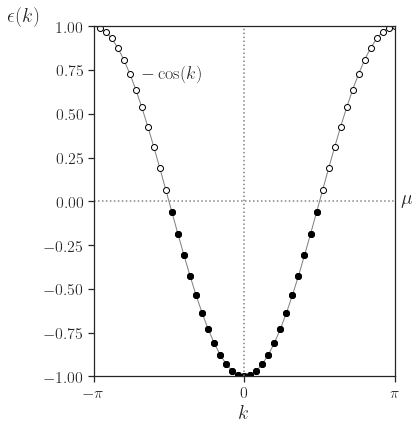

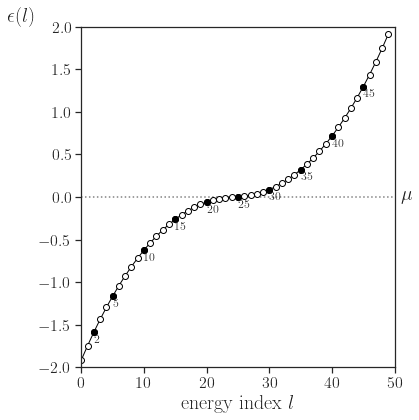

In [504]:
L = 50
fontSize = 20
ticksize = 16

sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (6,6)})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

def SpectrumH0(L,pbc):
    H_0 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = -1/2
        H_0[i+1,i] = -1/2
    if pbc == True:
        H_0[0,L-1] = -1/2
        H_0[L-1,0] = -1/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    return eigenvalues0

def SpectrumSSD(L,pbc):
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues1, V = np.linalg.eigh(H_1)
    return eigenvalues1


# plt.ticklabel_format(axis='y', scilimits=[0,0])
# plt.tick_params(axis='both', which='major', labelsize=19)
# plt.plot(diag_state, label=r"$L$ = {}".format(L))
# plt.ylabel(r'$E$',fontsize = 18)

def f(x):
    value = np.cos(2*np.pi*x/L + np.pi)
    return value 


def disperionrelationSSD():
    plotpoints = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45]
    plt.xlabel(r'energy index $l$', fontsize = fontSize)
    plt.ylabel(r'$\epsilon(l)$',fontsize = fontSize, rotation = '0', loc='top')
    plt.tight_layout()
    plt.xlim(0,L)
    plt.axhline(y = 0, color = 'grey', linestyle = ':')
    plt.text(51,-0.03 ,r'$\mu$', fontsize = fontSize)
    
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    
#     plt.yticks([-2,-1,0,1,2])
    plt.ylim(-2,2)
    
#     plt.plot(SpectrumSSD(L,True), '-o', fillstyle = 'none', color = 'grey', linewidth = 1)
    plt.plot(SpectrumSSD(L,True), '-', color = 'black', linewidth = 1)
    plt.plot(SpectrumSSD(L,True), 'o', color = 'white', linewidth = 1, markeredgecolor = 'black')
    
    for i in plotpoints:
        plt.plot(i,SpectrumSSD(L,True)[i], 'o', color = 'black')
        plt.annotate(i, (i, SpectrumSSD(L,True)[i] -0.12))
    plt.tight_layout()
    plt.savefig('dispersionrelationSSD.pdf')
    plt.show()
    
    
    
def dispersionrelationH0():
    Npar = np.where(SpectrumH0(L, True) < 1e-7)[0].shape[0]
    x = [0] 
    for i in range(1, int(L/2) +1): 
        if i == int(L/2):
            x.append(i)
        else:
            x.append(-i)
            x.append(i)
        i += 1
        
    z = [i for i in range(-L,L)]
    y = [f(i) for i in range(-L, L)]
    
    
    plt.text(-L/2 + 8, 0.7, r'$-\cos(k)$', fontsize=18)
    
    plt.plot(z, y, color = 'grey', linewidth = 1)    
#     plt.plot(x,SpectrumH0(L, True), 'o', color = 'black', fillstyle = 'none')
    plt.axhline(y = 0, color = 'grey', linestyle = ':')
    plt.plot(x,SpectrumH0(L, True), 'o', color = 'white', markeredgecolor = 'black')
    plt.plot(x[:Npar],SpectrumH0(L, True)[:Npar], 'o', color = 'black')
    
    plt.text(26,-0.01 ,r'$\mu$', fontsize = fontSize)
    plt.axvline(x = 0, color = 'grey', linestyle = ':')
    

    
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    
    
#     plt.xticks([-int(L/2), -int(L/4), 0, int(L/4), int(L/2)],[r'$-\pi$',r'$-\pi/2', '0', r'$\pi/2$', r'$\pi$'])
    plt.xticks([-int(L/2), 0, int(L/2)],[r'$-\pi$', '0', r'$\pi$'])
#     plt.yticks([-1,-0.5,0,0.5,1])
    
    plt.xlabel(r'$k$', fontsize = fontSize)
    plt.ylabel(r'$\epsilon(k)$',fontsize = fontSize, rotation = '0', loc='top')
    
    plt.xlim(-L/2,L/2)
    plt.ylim(-1,1)
    plt.tight_layout()
    plt.savefig('dispersionrelationH0.pdf')
    plt.show()


dispersionrelationH0()
disperionrelationSSD()
#     plt.annotate(i, SpectrumSSD(L,True)[i], )

# plt.plot(averageEnergyDensitySSD(50,0.95,0.05, True), 'bo')
# plt.plot(SpectrumSSD(L,True), 'o', fillstyle = 'none', color = 'grey')



# x = [0,-1,1,-2,2,-3,3,-4,4,-5,5]





# plt.axvline(x = int(L/2), color = 'grey', linestyle = '-', label = 'Test')
# plt.plot(SpectrumH0(50,True), 'bo')



# plt.plot(averageEnergyDensityH0(100,0.95,0.05,True),'bo', label = 'PBC')
# plt.plot(averageEnergyDensityH0(100,0.95,0.05,False),'^g', label = 'OBC')
# plt.plot(averageEnergyDensitySSD(100,0.95,0.05, False), 'Dr',label = 'SSD')

# plt.plot(diag_E_density,  'g^', label = 'OBC')
# plt.plot(diag_E_density, 'bo', label = 'PBC') 
# plt.legend(fontsize = 17)

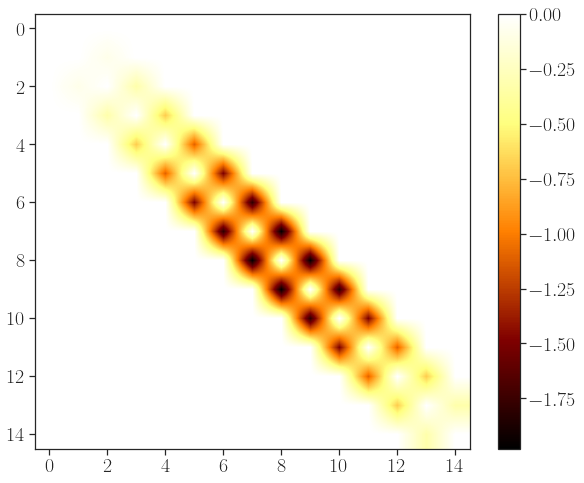

In [77]:
ticksize = 20
def MatrixColorMap(L, pbc):
    def F(x):
        return 2*np.sin(np.pi*x/L)**2

    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = -1/2
        H_0[i+1,i] = -1/2
        H_1[i, i+1] = -F(i)
        H_1[i+1,i] = -F(i)
    if pbc == True:
        H_0[0,L-1] = -1/2
        H_0[L-1,0] = -1/2
        H_1[0,L-1] = -F(0)
        H_1[L-1,0] = -F(L)
    return [H_0, H_1]

# fig = plt.figure()
# ax1 = fig.add_subplot(121)
# ax2 = fig.add_subplot(122)
matrix = MatrixColorMap(15,True)[1]
plt.imshow(matrix, cmap = 'afmhot', interpolation = 'bilinear')
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=ticksize)
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
plt.savefig('ColorMapMatrixH0_SSD.pdf')
# ax2.imshow(MatrixColorMap(15,False)[0], cmap = 'afmhot', interpolation = 'bilinear')
# ax2.imshow(MatrixColorMap(15,True)[1], cmap = 'afmhot', interpolation = 'bilinear')
# ax1.imshow(MatrixColorMap(10,True)[0], cmap = 'winter')
# ax2.imshow(MatrixColorMap(10 ,True)[1], cmap = 'winter')
plt.show()

-0.0031820515953773954


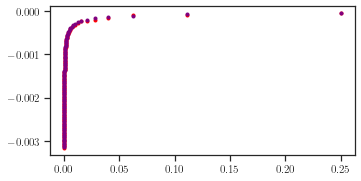

In [44]:
from mpmath import *
mp.dps = 25; mp.pretty = True

L = 50
fontSize = 20
ticksize = 16

sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (12,6)})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})

def SpectrumH0(L,pbc):
    H_0 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = -1/2
        H_0[i+1,i] = -1/2
    if pbc == True:
        H_0[0,L-1] = -1/2
        H_0[L-1,0] = -1/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    Npar = np.where(eigenvalues0 < 1e-7)[0].shape[0]
    return np.sum(eigenvalues0[:Npar])

def SpectrumSSD(L,pbc):
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues1, V = np.linalg.eigh(H_1)
    Npar = np.where(eigenvalues1 < 1e-7)[0].shape[0]
    return np.sum(eigenvalues1[:Npar])

L = 100
N = [i for i in range(2,L)]


e_0 = []
for i in range(2, L):
    e_0.append(SpectrumH0(i, True)/L**2)

print(np.sum(SpectrumH0(L, True)/L**2))


    
# norm = []
# for i in range(1, L-1):
#     norm.append(np.sin(i*np.pi/L)**2)
# norm = np.sum(norm)

norm = cot(np.pi/(2*L))
# print(norm)

e_0SSD = []
for i in range(2, L):
    e_0SSD.append(SpectrumSSD(i, True)/norm)
    
e_01 = []

for i in range(2, L):
    e_01.append(SpectrumH0(i, False)/L**2)
    


# for i in range(0,len(e_0)):
#     e[i] = e_0[i] - e_0SSD[i]
Ninv =[]
for i in range(len(N)):
    Ninv.append(1/N[i]**2)
    
    
fig = plt.figure()
ax1 = fig.add_subplot(221)
# ax2 = fig.add_subplot(222)
# ax3 = fig.add_subplot(223)
# ax1.plot(Ninv, e_0SSD, '.', color = 'blue')
ax1.plot(Ninv, e_0, '.', color = 'red')
ax1.plot(Ninv, e_01, '.', color = 'purple')
# ax1.set_xlim(0, 0.03)
# ax1.imshow(MatrixColorMap(10,True)[0], cmap = 'winter')
# ax2.imshow(MatrixColorMap(10 ,True)[1], cmap = 'winter')
plt.show()




## Quasiparticle Picture

10.010128698448966
10.010128698448966
10.010128698448966
10.010128698448966
10.010128698448966
10.010128698448966
10.010128698448966
10.010128698448966
10.010128698448966


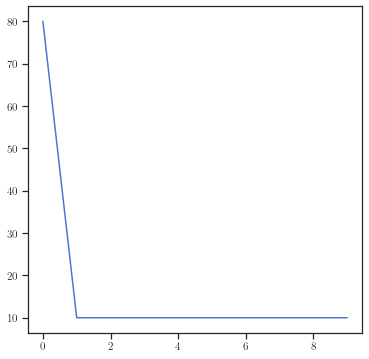

In [444]:
import scipy.integrate as integrate
from scipy.integrate import quad
cycles = 10
L = 100
position = [None] * cycles
initial_position = 80
position[0] = initial_position
T0 = 0.05*L 
T1 = 0.05*L
# number_of_bounces = [None]*cycles
# number_of_bounces[0] = 0

def integrand(t):
    return 2*np.sin(np.arctan(2*np.pi*t))**2

# I = quad(integrand, 0, T1)
# print(I[0])

for i in range(1, cycles):
#     v_SSD = 2*np.sin(np.pi*position[i-1]/L)**2
    I = quad(integrand,0,T1)
    x = I[0] + T_0
    position[i] = distance
#     if number_of_bounces[i-1]%2 == 0:
#         position[i] = position[i-1] + distance
#     elif number_of_bounces[i-1]%2 != 0:
#         position[i] = position[i-1] - distance
#     elif position[i] > L:
#         position[i] = position[i]%L
#     elif position[i] < 0 and position[i] < -L:
#         position[i] = -position[i]
    
#     number_of_bounces[i] = ((position[i] - position[i]%L)/L)
    # Boundary conditions

        
cycles_arr = [i for i in range(0,cycles)]
plt.plot(cycles_arr, position)
plt.show()

### Evolution of Energy Eigenvalues

[-1.61300487e+00 -9.44642741e-01 -4.71095807e-01 -1.57529326e-01
 -5.42554145e-33  5.42554145e-33  1.57529326e-01  4.71095807e-01
  9.44642741e-01  1.61300487e+00]
[-1.         -0.80901699 -0.80901699 -0.30901699 -0.30901699  0.30901699
  0.30901699  0.80901699  0.80901699  1.        ]


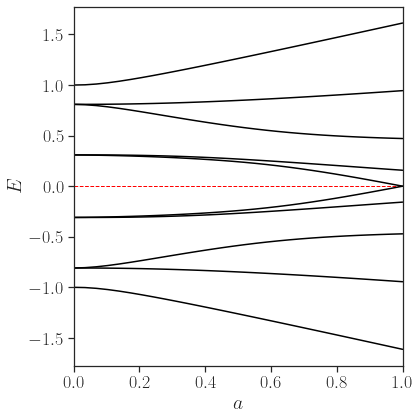

In [512]:
fontSize = 20
ticksize = 18
L = 10

def F(x):
    return 2*np.sin(np.pi*x/L)**2

def SpectrumSSD(L,a,pbc):
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_1[i, i+1] = -1/2*((1-a) + a*F(i))
        H_1[i+1,i] = -1/2*((1-a) + a*F(i))
    if pbc == True:
        H_1[0,L-1] = -1/2*((1-a) + a*F(L))
        H_1[L-1,0] = -1/2*((1-a) + a*F(L))
    eigenvalues1, V = np.linalg.eigh(H_1)
    return eigenvalues1

a = np.linspace(0,1,30)
# x = np.empty((len(a),L**2), int)
# print(np.shape(x))


print(SpectrumSSD(L,1,True))
print(SpectrumSSD(L,0,True))
y = []

for i in a:
    eigvals = SpectrumSSD(L,i,True)
    eig = eigvals.tolist()
    y.append(eig)
    
fig, ax2 = plt.subplots(1,1, figsize = (6,6))

plt.axhline(y = 0, color = 'r', linestyle = '--', linewidth = 1)
# plt.axvline(x = 0.5, color = 'grey', linestyle = '--', linewidth = 1)
ax2.plot(a,y,'-', color = 'black')
# ax2.plot(n,measurement, '--', linewidth = 1, color = 'grey')
    
#     ax2.text(-1, 0.004, r"$T_0$ = {}L".format(T_0), color="black", fontsize=fontSize)
#     ax2.text(-1, 0.0042, r"$T_1$ = {}L".format(T_1), color="black", fontsize=fontSize)
#     ax2.text(-1, 0.0044, r"$L$ = {}".format(L), color="black", fontsize=fontSize)
#     ax2.text(-1, 0.0046, r"PBC = {}".format(PBC), color = "black", fontsize=fontSize)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
plt.xticks(fontsize=ticksize)
plt.yticks(fontsize=ticksize)
ax2.set_xlim(0,1)
# ax2.set_xlim(0.8,1.0)
# ax2.set_ylim(-0.5, 0.5)
# plt.ylim(-0.5,0.5)
    
ax2.yaxis.set_major_formatter(formatter) 
tx = ax2.yaxis.get_offset_text()
tx.set_fontsize(20)
    
ax2.set_ylabel(r"$E$", fontsize = fontSize)
ax2.set_xlabel(r"$a$", fontsize=fontSize)
plt.tight_layout()
plt.savefig('EvolutionEnergies1D.pdf')
plt.show()

[[-1.79271120877233, -1.4066391655075903, -1.075419135961598, -0.794954249672095, -0.5615957034083113, -0.37215170152619814, -0.22384689351584927, -0.11397026727174067, -0.03862719501263323, -5.2653151186660394e-33, 5.2653151186660435e-33, 0.038627195012633224, 0.11397026727174069, 0.2238468935158493, 0.3721517015261982, 0.5615957034083111, 0.7949542496720954, 1.0754191359615983, 1.4066391655075896, 1.7927112087723307], [-8.267794286753147e-17, -1.8062679929849625e-17, -8.488408061703191e-18, -1.533524781150495e-18, -8.695418907190414e-19, -4.511717884025554e-19, -2.5990248101139852e-19, -1.2690823116455076e-19, -1.1316679072735765e-19, -4.6918253596792534e-20, 1.5552239220648058e-20, 3.195039814348973e-20, 3.569494789703376e-19, 4.287469176161935e-19, 5.769413362234622e-19, 7.96778031916505e-19, 2.1635348468812427e-18, 1.9978120514966374e-17, 1.8041778864904006e-16, 0.999999999999999], [-2.2223370835473147e-16, -6.803723242717089e-17, -1.989054400425487e-17, -1.6839132924104394e-17, -

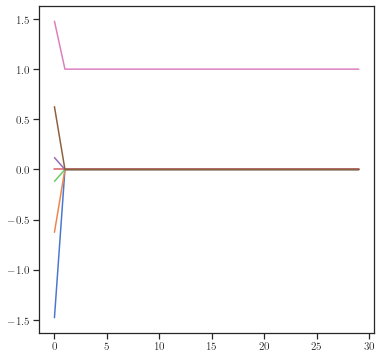

In [562]:
def EvolutionEigenvalues(L,cycles,T_0, T_1, pbc):
    y = []
    for i in a:
        eigvals = SpectrumSSD(L,i,True)
        eig = eigvals.tolist()
    y.append(eig)
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2

    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    state = U[:,int(L/2)]@((U.H)[int(L/2),:])
    
    eig0 = np.linalg.eigh(state)
    y.append(eig0[0].tolist())
    
    
    for i in range(cycles - 1):
        mathcalW = mathcalW@W_total
        state1 = mathcalW[:,int(L/2)]@((mathcalW.H)[int(L/2),:])
        
        eig1 = np.linalg.eigh(state1)
        y.append(eig1[0].tolist())
    print(y)
    return y

EvolutionEigenvalues(20, 17, 0.95, 0.05, True)
    
n_cycles = [i for i in range(0, 30)]


plt.plot(n_cycles, EvolutionEigenvalues(7, 29, 0.95, 0.05, True))

AttributeError: 'tuple' object has no attribute 'set_ylabel'

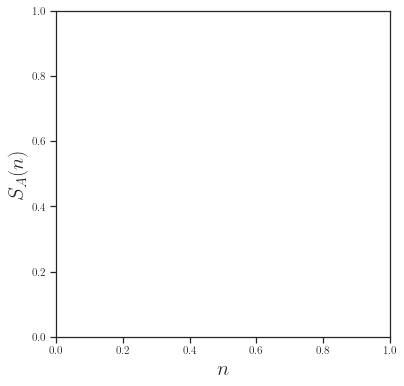

In [414]:
# L = 500
T0 = 0.9
T1 = 0.9
fontsize = 20
cycles1 = 18

def entropy_cycles(L, T_0, T_1, cycles, cutoff):
    Entropy = [None]*cycles1
    for i in range(0,cycles):
        state = obtainedstate(L,i, T_0, T_1, True)
        Entropy[i] = entropy(state, 0, cutoff)
    return Entropy

sns.set(style = st,palette = sns.color_palette("muted"), rc={'figure.figsize': (10,8)})
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": ["Computer Modern Roman"]})   
fontSize = 21
ticksize = 19

cycles_arr = [i for i in range(0,cycles1)]

L=500
cutoff_array = [int(0.5*L), int(0.3*L), int(0.2*L), int(0.1*L), int(0.05*L)]

fig, ax1 = plt.subplots(1,1, figsize = (6,6))

ax1.set_xlabel(r'$n$', fontsize = fontSize)
# ax1.set_xlim(1,len(cycles_arr))
ax1.set_ylabel(r'$S_A(n)$', fontsize = fontSize)
ax2.set_ylabel(r'$\log(E(n))/6$', fontsize = fontSize)


# handles = [mpl_patches.Rectangle((0, 0), 1, 1, fc="white", ec="white", 
#                              lw=0, alpha=0)] * 3

# labels = []
# labels.append(r"$T_0 = {}L$".format(T0))
# labels.append(r"$T_1 = {}L$".format(T1))
# labels.append(r"PBC = {}".format(PBC))

# leg = ax1.legend(handles, labels, loc='lower right', fontsize=fontSize, 
#       fancybox=True, framealpha=0.7, 
#       handlelength=0, handletextpad=0)

for j in cutoff_array:
    markerstyle = '.'
    ax1.plot(cycles_arr, entropy_cycles(L, T_0, T_1, cycles1, j), markerstyle, label = r'$|A| = {}$'.format(j))

# markerstyle = '.'
# plt.plot(cycles_arr, entropy_cycles(L, T0, T1, cycles1), markerstyle, label = r'$L = {}$'.format(L))

plt.ylabel(r'$S_A(n) - S_A(0)$', fontsize = fontSize)
plt.xlabel(r'$n$',fontsize = fontSize)
text = plt.gca().yaxis.get_offset_text()
text.set_size(18)
# plt.xticks(fontsize=ticksize)
# plt.yticks(fontsize=ticksize)
plt.tight_layout()
plt.ticklabel_format(axis='y', scilimits=[0,0])
plt.tick_params(axis='both', which='major', labelsize=ticksize)
plt.legend(fontsize = fontSize)
# ax1.add_artist(leg)
plt.show()

### Loschmidt Echo

In [ ]:
scipy.linalg.expm(A)


T_0 = T_0 * L
T_1 = T_1 * L
def F(x):
    return 2*np.sin(np.pi*x/L)**2

H_0 = np.zeros((L,L))
H_1 = np.zeros((L,L))
for i in range(L-1):
    H_0[i, i+1] = 1/2
    H_0[i+1,i] = 1/2
    H_1[i, i+1] = F(i)/2
    H_1[i+1,i] = F(i)/2
if pbc == True:
    H_0[0,L-1] = 1/2
    H_0[L-1,0] = 1/2
    H_1[0,L-1] = F(0)/2
    H_1[L-1,0] = F(L)/2
eigenvalues0, U = np.linalg.eigh(H_0)
eigenvalues1, V = np.linalg.eigh(H_1)
U = np.matrix(U)
V = np.matrix(V)
    
exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
exponential_E0 = np.matrix(np.diag(exponential_E0))
exponential_E1 = np.matrix(np.diag(exponential_E1))

W = V.H@U
mathcalW = U
W1_T1 = exponential_E1@W
W0_T0 = exponential_E0@(W.H)
W_total = W0_T0@W1_T1
E_density = []
state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
E_density.append([1/2*(state[i,i+1] + state[i+1, i])
                  for i in range(L-1)])
for i in range(cycles - 1):
    mathcalW = mathcalW@W_total
    state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])
    E_density.append([1/2*(state[i, i+1] + state[i+1, i]) 
                          for i in range(L-1)])



Ground_state =  U[:,:int(L/2)]@((U.H)[:int(L/2),:])
Ground_State_Energy_H0 = 0


# Energies for n cycles
#     n = [i for i in range(cycles)
Floquet_cycles = np.linalg.matrix_power(W_total, cycles)
mathcal_W = np.dot(U, Floquet_cycles)
mathcal_W_her = np.conjugate(mathcal_W.transpose())
mathcal_W_halffilling = mathcal_W[:,:int(L/2)]
mathcal_W_her_halffilling = mathcal_W_her[:int(L/2),:]
state = np.dot(mathcal_W_halffilling, mathcal_W_her_halffilling)
Total_Energy = 0
for l in range(L-1):
    Total_Energy += 0.5*state[l,l+1] + 0.5*state[l+1,l]
Total_Energy = Total_Energy - Ground_State_Energy_H0

## Eigenstates Floquet System

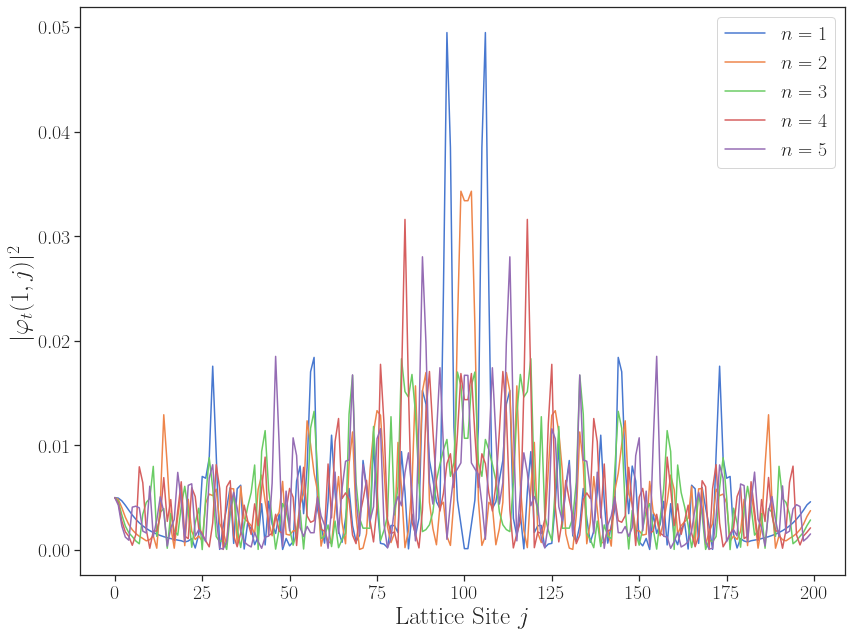

In [28]:
fontSize = 20
def eigenstate_profileSSD(L,pbc,eigenstate_nr:int):
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_1[i, i+1] = -F(i)/2
        H_1[i+1,i] = -F(i)/2
    if pbc == True:
        H_1[0,L-1] = -F(0)/2
        H_1[L-1,0] = -F(L)/2
    eigenvalues1, V = np.linalg.eigh(H_1)
    V = np.matrix(V)
    E_density = []
#     state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    state = V[:,(eigenstate_nr-1):eigenstate_nr]@((V.H)[(eigenstate_nr-1):eigenstate_nr,:])
    E_density.append([(state[i,i])
                          for i in range(L)])
    diag_E_density = [E_density[0][i] for i in range(0,L)]
    print(np.sum(diag_E_density))
    return diag_E_density


def obtainedstateFloquet(L,cycles,T_0, T_1, pbc, eigenstate_nr:int):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,(eigenstate_nr-1):eigenstate_nr]@((U.H)[(eigenstate_nr-1):eigenstate_nr,:])
    for i in range(cycles):
        mathcalW = mathcalW@W_total
        state2 = mathcalW[:,(eigenstate_nr-1):eigenstate_nr]@((mathcalW.H)[(eigenstate_nr-1):eigenstate_nr,:])
    E_density.append([(state2[i,i])
                          for i in range(L)])
    diag_E_density = [E_density[0][i] for i in range(0,L)]
    return diag_E_density

obtainedstateFloquet(200, 10, 0.9,0.9, True, 3)

plt.xlabel(r'Lattice Site $j$', fontsize = 25)
plt.ylabel(r'$|\varphi_t(1, j)|^2$',fontsize = 25)



cycles_array = [i for i in range(1, 6)]
for i in cycles_array:
#     plt.plot(obtainedstateFloquet(200, i, 0.01, 0.04, True, 1), label = r'$n = {}$'.format(i))
#     plt.plot(obtainedstateFloquet(200, i, 0.01, 0.04, True, 5), label = r'$n = {}$'.format(i))
#     plt.plot(obtainedstateFloquet(200, i, 0.01, 0.04, True, 20), label = r'$n = {}$'.format(i))
#     plt.plot(obtainedstateFloquet(200, i, 0.01, 0.04, True, 8), label = r'$n = {}$'.format(i))
    
#     plt.plot(obtainedstateFloquet(200, i, 0.95, 0.05, True, 1), label = r'$n = {}$'.format(i))
    plt.plot(obtainedstateFloquet(200, i, 0, 1, True, 1), label = r'$n = {}$'.format(i))
    
    
# 
#     plt.plot(obtainedstateFloquet(200, i,0, 1, True, 1), label = r'$n = {}$'.format(i))
# plt.plot(averageEnergyDensityH0(L,True)[0 :L-1],'bo', label = 'PBC', fillstyle=fill)
# plt.plot(averageEnergyDensityH0(L,False)[1:L-1],'^g', label = 'OBC', fillstyle=fill)
# plt.plot(averageEnergyDensitySSD(L ,False)[2:L-1], 'dr',label = 'SSD', fillstyle=fill )
# plt.ylim((0.3,0.9))
# plt.xlim(0,L)
plt.xticks(fontsize=fontSize)
plt.ticklabel_format(useOffset=False)
plt.yticks(fontsize=fontSize)
# plt.title("Bond energy at half-filling")
# plt.plot(diag_E_density,  'g^', label = 'OBC')
# plt.plot(diag_E_density, 'bo', label = 'PBC') 
plt.legend(fontsize = fontSize)
plt.tight_layout()
# plt.savefig('Eigenstates_ProfileSSD.pdf')
# <!-- plt.savefig('Occupation_number_H1.pdf') -->
plt.show()

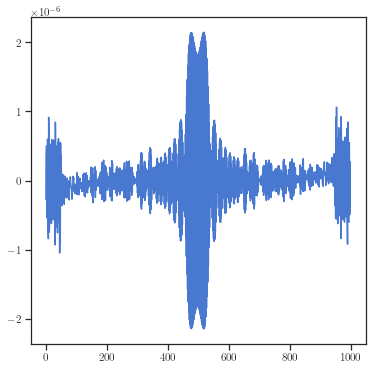

In [409]:
def particle_current(c_state, L):
    e_d = [c_state[i, i + 1] - c_state[i, i - 1] for i in range(1, L - 1)]
    return e_d


def obtainedstate(L,cycles,T_0, T_1, pbc):
    T_0 = T_0 * L
    T_1 = T_1 * L
    def F(x):
        return 2*np.sin(np.pi*x/L)**2
    H_0 = np.zeros((L,L))
    H_1 = np.zeros((L,L))
    for i in range(L-1):
        H_0[i, i+1] = 1/2
        H_0[i+1,i] = 1/2
        H_1[i, i+1] = F(i)/2
        H_1[i+1,i] = F(i)/2
    if pbc == True:
        H_0[0,L-1] = 1/2
        H_0[L-1,0] = 1/2
        H_1[0,L-1] = F(0)/2
        H_1[L-1,0] = F(L)/2
    eigenvalues0, U = np.linalg.eigh(H_0)
    eigenvalues1, V = np.linalg.eigh(H_1)
    U = np.matrix(U)
    V = np.matrix(V)
    
    exponential_E0 = np.exp(-1j*T_0*eigenvalues0)
    exponential_E1 = np.exp(-1j*T_1*eigenvalues1)
    exponential_E0 = np.matrix(np.diag(exponential_E0))
    exponential_E1 = np.matrix(np.diag(exponential_E1))
    
    W = V.H@U
    mathcalW = U
    W1_T1 = exponential_E1@W
    W0_T0 = exponential_E0@(W.H)
    W_total = W0_T0@W1_T1
    E_density = []
    state = U[:,:int(L/2)]@((U.H)[:int(L/2),:])
    for i in range(cycles):
        mathcalW = mathcalW@W_total
        state = mathcalW[:,:int(L/2)]@((mathcalW.H)[:int(L/2),:])

    return state


L = 1000
# T0 = 0.95
# T1 = 0.05

T0 = 0.05
T1 = 0.05

plt.plot(particle_current(obtainedstate(L,6,T0, T1, True), L))

In [411]:
import qutip as qu

def F(x):
    return 2*np.sin(np.pi*x/L)**2

L = 500
H_0 = np.zeros((L,L))
H_1 = np.zeros((L,L))
for i in range(L-1):
    H_0[i, i+1] = 1/2
    H_0[i+1,i] = 1/2
    H_1[i, i+1] = F(i)/2
    H_1[i+1,i] = F(i)/2
    H_0[0,L-1] = 1/2
    H_0[L-1,0] = 1/2
    H_1[0,L-1] = F(0)/2
    H_1[L-1,0] = F(L)/2
    

omega = 1

T = 1*omega

args = {'w': omega}
H = [H_0, [H_1, 'w*t']]
f_modes_0, f_energies = qu.floquet_modes(H, T, args)

Exception: Invalid td-list element.